<a href="https://colab.research.google.com/github/ClaudiaMarano/Anomaly-Detection-and-Prediction/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series: Anomaly Detection & Anomaly Prediction

Questo file documenta l'implementazione dei task di **Anomaly Detection** e **Prediction** su serie temporali.

Le serie temporali analizzate derivano da dati acquisiti durante un processo fisico di riempimento e svuotamento di serbatoi (a cui faremo riferimento come Dataset Fisico), combinati con dati di rete generati durante lo scambio di informazioni associato al processo (Dataset di Network).

L'obiettivo del progetto è sviluppare modelli di **Deep Learning** capaci di:
- **Rilevare** la presenza di anomalie nel processo (Anomaly Detection).
- **Predire** la possibile insorgenza di anomalie (Anomaly Prediction).

# Data Preprocessing

## Preprocessing Network Dataset

In questa sezione viene effettuato il preprocessing per il dataset di Network.

### Setup

Iniziamo installando e importando le librerie necessarie per il preprocessing.

In [1]:
# Importazione delle librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

### Caricamento dataset di rete

Carichiamo il dataset importandolo da Google Drive.

Per fare ciò, è necessario importare preventivamente il dataset di Network sul drive e selezionarlo fra le cartelle che compaiono quando si avvia il codice.

In [2]:
from google.colab import drive
import os
import ipywidgets as widgets
from IPython.display import display

# Monta Google Drive
drive.mount('/content/drive')

# Percorso di Google Drive
root_path = '/content/drive/My Drive/'

# Elenca le cartelle disponibili anella radice
folders = [name for name in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, name))]

# Crea un menu a tendina per selezionare una cartella per i file di rete
network_folder_dropdown = widgets.Dropdown(
    options=folders,
    description='Rete Folder:',
    disabled=False,
)

# Variabile globale per salvare la cartella selezionata per i file di rete
network_selected_folder = None

# Funzione per aggiornare la cartella di rete selezionata
def on_network_folder_selection(change):
    global network_selected_folder
    network_selected_folder = os.path.join(root_path, change['new'])
    print(f"Hai selezionato la cartella di rete: {network_selected_folder}")

    # Elenca i file nella cartella selezionata
    file_list = [file for file in os.listdir(network_selected_folder) if os.path.isfile(os.path.join(network_selected_folder, file))]

    if file_list:
        # Mostra i file disponibili nella cartella selezionata
        print("File disponibili nella cartella selezionata (Rete):")
        print(file_list)
    else:
        print("La cartella selezionata (Rete) non contiene file.")

# Mostra il menu a tendina per la cartella di rete
display(network_folder_dropdown)

# Assegna la funzione all'evento di selezione della cartella
network_folder_dropdown.observe(on_network_folder_selection, names='value')

Mounted at /content/drive


Dropdown(description='Rete Folder:', options=('Isi', 'Benvenuto', 'Modelli e metodi', 'Programmazione', 'Notab…

Hai selezionato la cartella di rete: /content/drive/My Drive/NetworkDataset
File disponibili nella cartella selezionata (Rete):
['attack_1.csv', 'attack_2.csv', 'attack_3.csv', 'attack_4.csv', 'normal.csv', 'processed_attack_1_resampled.csv', 'processed_attack_2_resampled.csv', 'processed_attack_3_resampled.csv', 'processed_attack_4_resampled.csv', 'processed_normal_resampled.csv']


### Creazione funzione di preprocessing

Creiamo la funzione per effettuare il preprocessing del dataset dei dati di network.

La funzione `preprocess_and_resample` carica un dataset temporale, seleziona le colonne rilevanti, effettua un resampling dei dati con statistiche aggregate, salva il risultato in un file CSV e genera grafici per l'analisi visiva.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_global_limits(normal_data, attack_data, features):
    """
    Calcola i limiti globali (min, max) per ogni feature nei dataset normale e di attacco.

    Parameters:
    - normal_data (DataFrame): Dataset normale resamplato.
    - attack_data (list of DataFrame): Lista di dataset di attacco resamplati.
    - features (list): Lista delle feature da considerare.

    Returns:
    - dict: Un dizionario con limiti per ogni feature.
    """
    limits = {}
    for feature in features:
        min_value = min(
            normal_data[feature].min(),
            *[attack[feature].min() for attack in attack_data]
        )
        max_value = max(
            normal_data[feature].max(),
            *[attack[feature].max() for attack in attack_data]
        )
        limits[feature] = (min_value, max_value)
    return limits

def preprocess_and_resample(file_path, output_path, time_column='Time', resample_interval='1s',
                            plot_data=True, label="Dataset", global_limits=None, plot_columns=None):
    """
    Preprocessa il dataset, effettua un resampling e opzionalmente genera plot delle feature.

    Parameters:
    - file_path (str): Percorso al file CSV da preprocessare.
    - output_path (str): Percorso dove salvare il file preprocessato e resamplato.
    - time_column (str): Nome della colonna temporale.
    - resample_interval (str): Intervallo di resampling (es. '30s', '1min').
    - plot_data (bool): Se True, genera i plot delle feature resamplate.
    - label (str): Etichetta per identificare il dataset nei grafici.
    - global_limits (dict): Limiti globali per ogni feature {feature_name: (min, max)}.
    - plot_columns (list): Lista delle colonne da plottare (default: tutte tranne `label_n`).
    """
    # Carica il dataset
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()

    # Controlla se la colonna temporale esiste
    if time_column not in df.columns:
        raise ValueError(f"La colonna temporale '{time_column}' non è presente nel dataset.")

    # Converte la colonna temporale in datetime
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce')

    # Preprocessing: consideriamo tutte le feature tranne label
    relevant_features = [
        time_column, 'mac_s', 'mac_d', 'ip_s', 'ip_d', 'sport', 'dport', 'proto', 'flags',
        'size', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst', 'modbus_response', 'label_n'
    ]
    relevant_features = [col for col in relevant_features if col in df.columns]  # Filtra solo le colonne presenti
    df = df[relevant_features]

    # Resampling
    df_resampled = df.set_index(time_column).resample(resample_interval).agg({
        'mac_s': ['nunique', 'count'],  # Numero unico e conteggio di MAC sorgente
        'mac_d': ['nunique', 'count'],  # Numero unico e conteggio di MAC destinazione
        'ip_s': 'nunique',  # Numero unico di IP sorgente
        'ip_d': 'nunique',  # Numero unico di IP destinazione
        'sport': 'nunique',  # Numero unico di porte sorgente
        'dport': 'nunique',  # Numero unico di porte destinazione
        'proto': 'nunique',  # Numero unico di protocolli
        'flags': 'nunique',  # Numero unico di flags
        'size': ['mean', 'sum', 'std'],  # Statistiche sulla dimensione
        'modbus_fn': 'count',  # Conteggio richieste Modbus
        'n_pkt_src': 'sum',  # Totale pacchetti inviati
        'n_pkt_dst': 'sum',  # Totale pacchetti ricevuti
        'modbus_response': 'count',  # Conteggio risposte Modbus
        'label_n': 'max'  # Se almeno un dato ha label_n=1, assegna 1
    }).fillna(0)

    # Rinomina le colonne
    df_resampled.columns = [
        'unique_mac_src_count', 'mac_src_count',  # MAC sorgente
        'unique_mac_dst_count', 'mac_dst_count',  # MAC destinazione
        'unique_ip_src_count', 'unique_ip_dst_count',  # IP unici
        'unique_sport_count', 'unique_dport_count',  # Porte uniche
        'unique_proto_count', 'unique_flags_count',  # Protocolli e flags unici
        'size_mean', 'size_sum', 'size_std',  # Statistiche sulle dimensioni
        'modbus_request_count',  # Richieste Modbus
        'total_packets_sent', 'total_packets_received',  # Totale pacchetti
        'modbus_response_count',  # Risposte Modbus
        'label_n'  # Etichetta
    ]

    # Salva il dataset preprocessato
    df_resampled.to_csv(output_path)
    print(f"Dataset resample salvato in: {output_path}")

    # Genera i plot se richiesto
    if plot_data:
        if plot_columns is None:
            plot_columns = [col for col in df_resampled.columns if col != 'label_n']

        for column in plot_columns:
            plt.figure(figsize=(12, 6))
            plt.plot(df_resampled.index, df_resampled[column], label=f"{label}: {column}")
            plt.title(f"{column} nel tempo ({resample_interval})")
            plt.xlabel("Time")
            plt.ylabel(column)
            if global_limits and column in global_limits:
                plt.ylim(global_limits[column])
            plt.legend()
            plt.grid()
            plt.show()

    return df_resampled

### Esecuzione del preprocessing

Eseguiamo il preprocessing per il file "normal.csv". Questo file contiene solo dati di rete in condizioni di normalità.

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_normal_resampled.csv


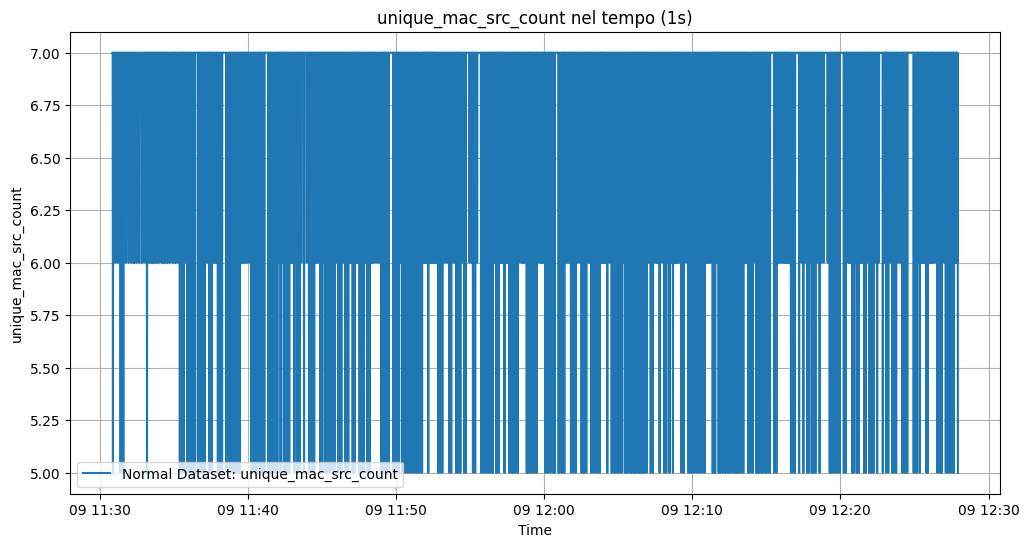

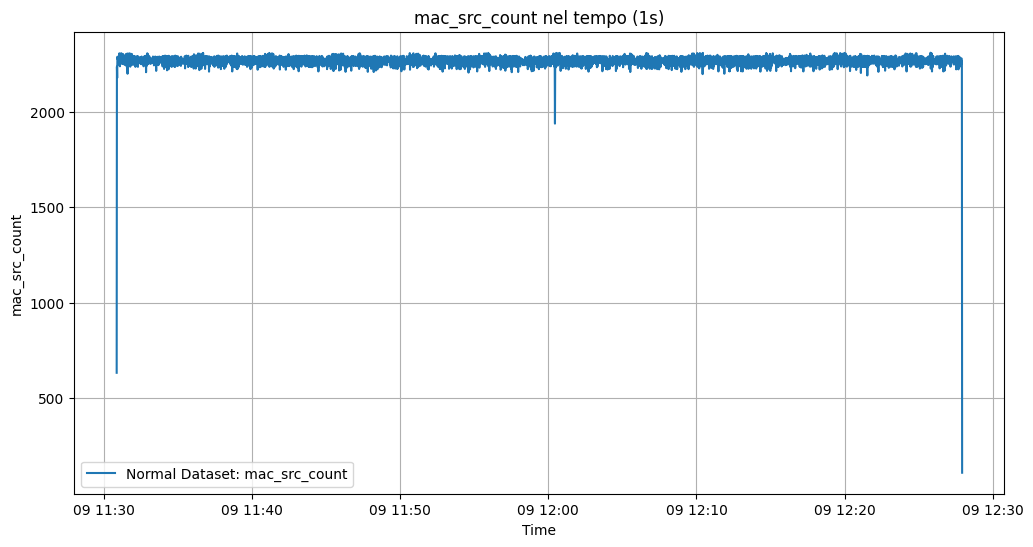

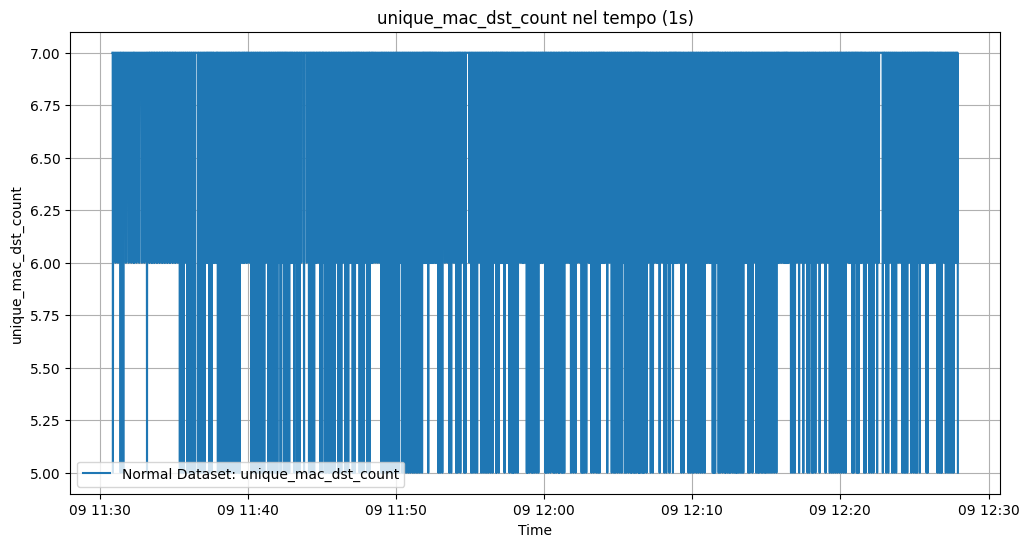

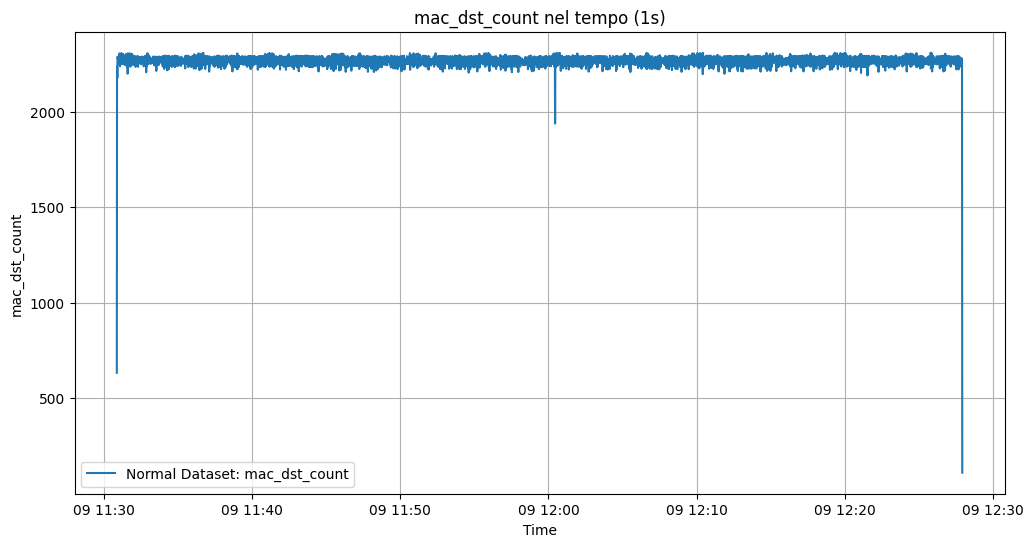

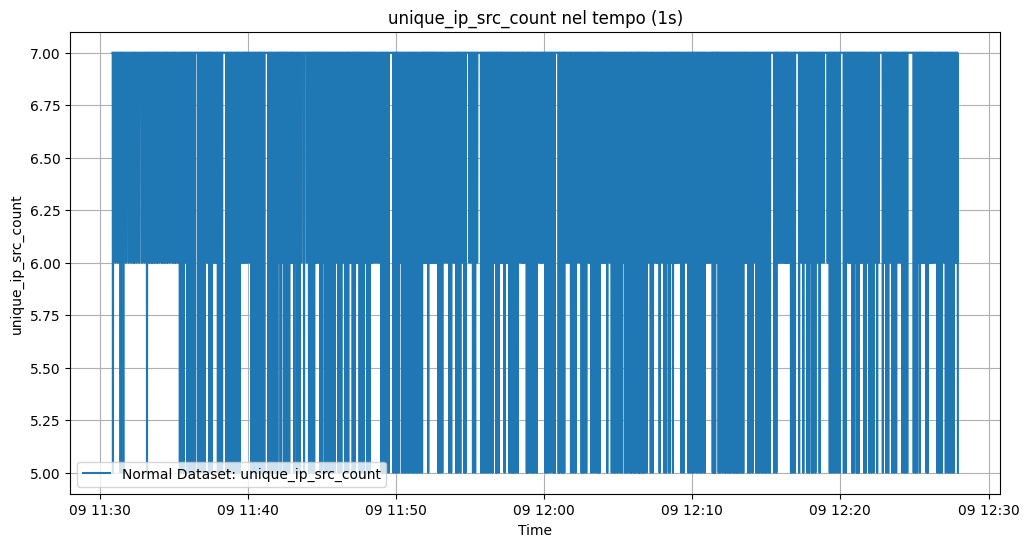

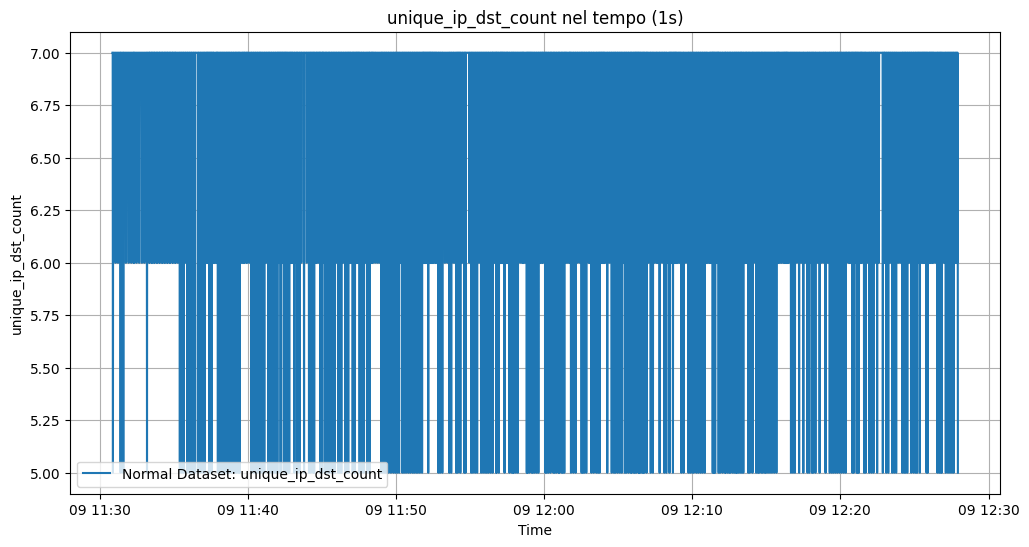

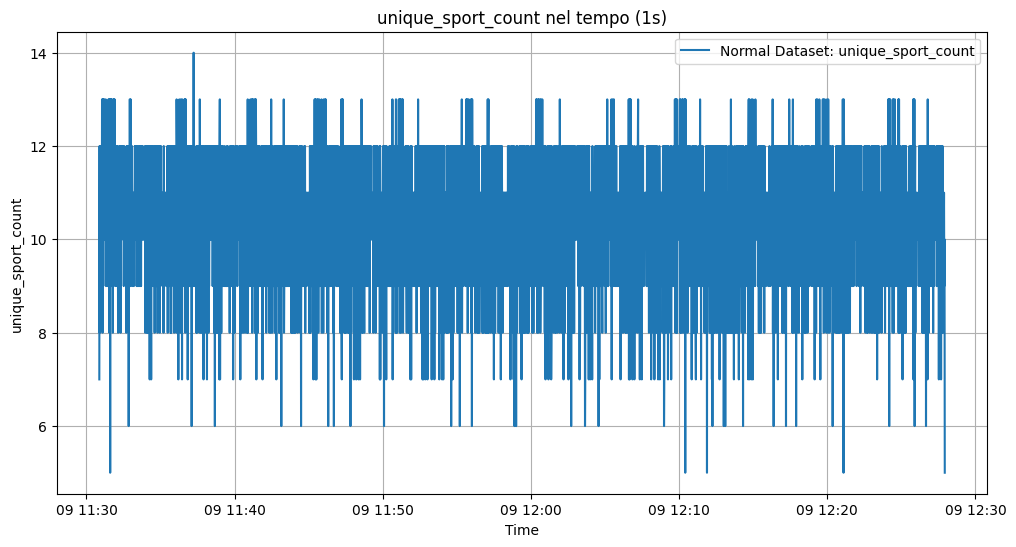

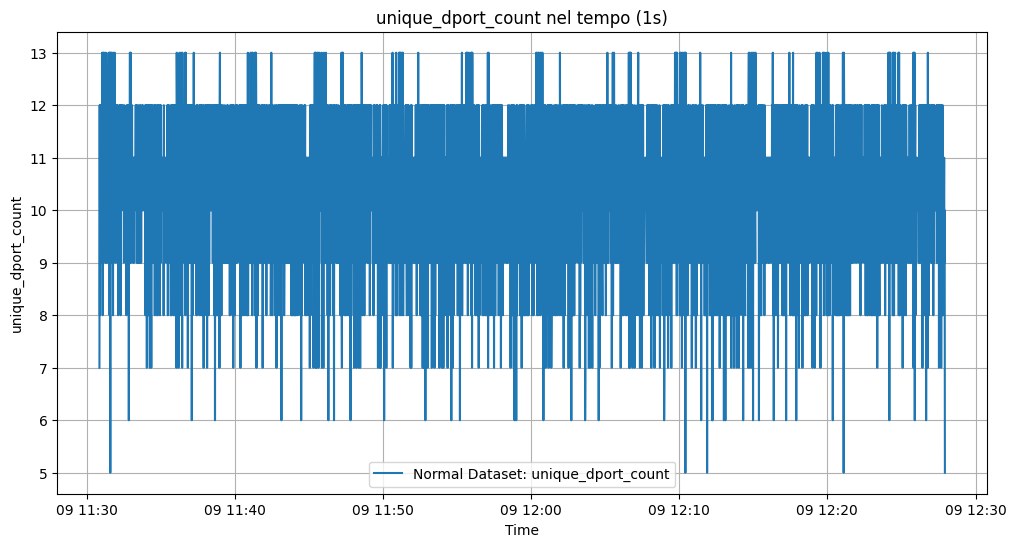

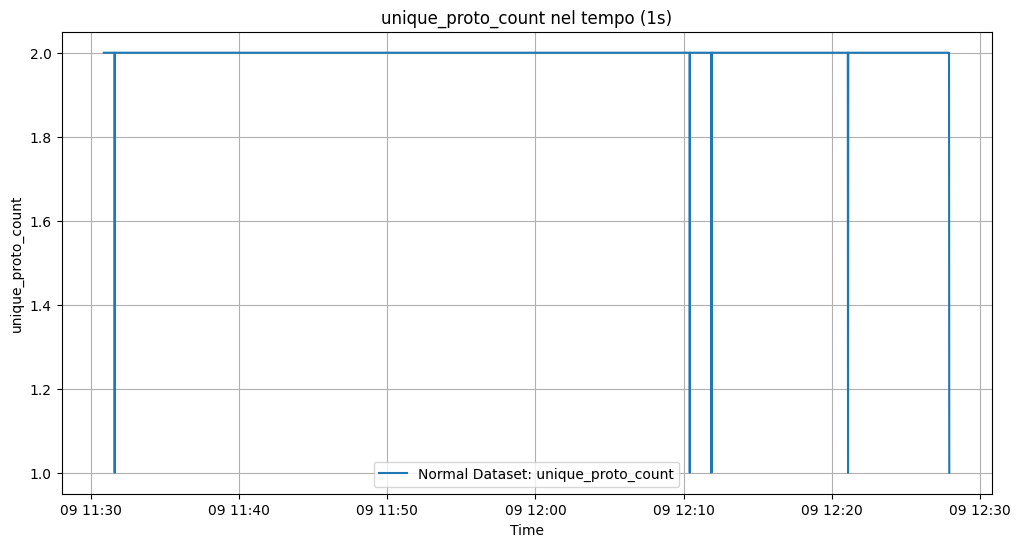

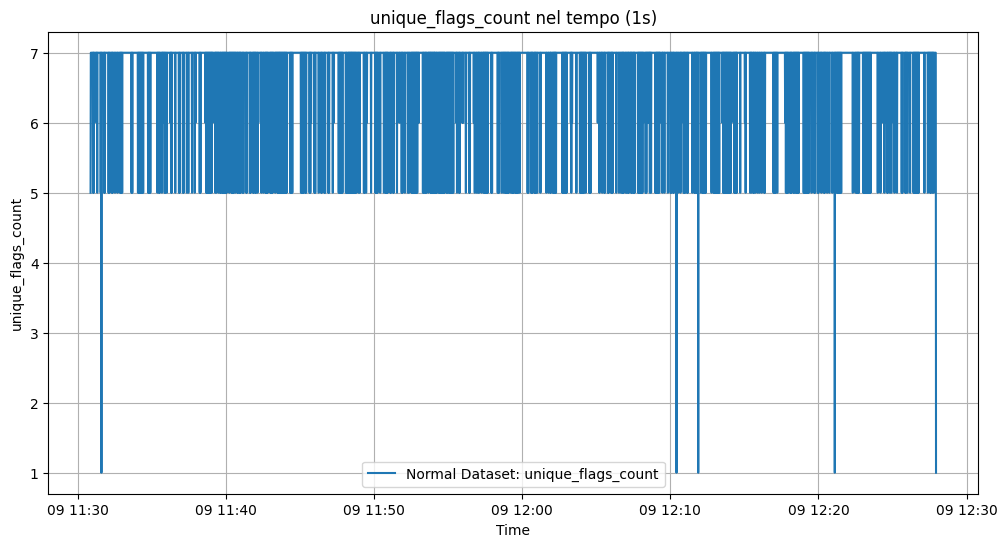

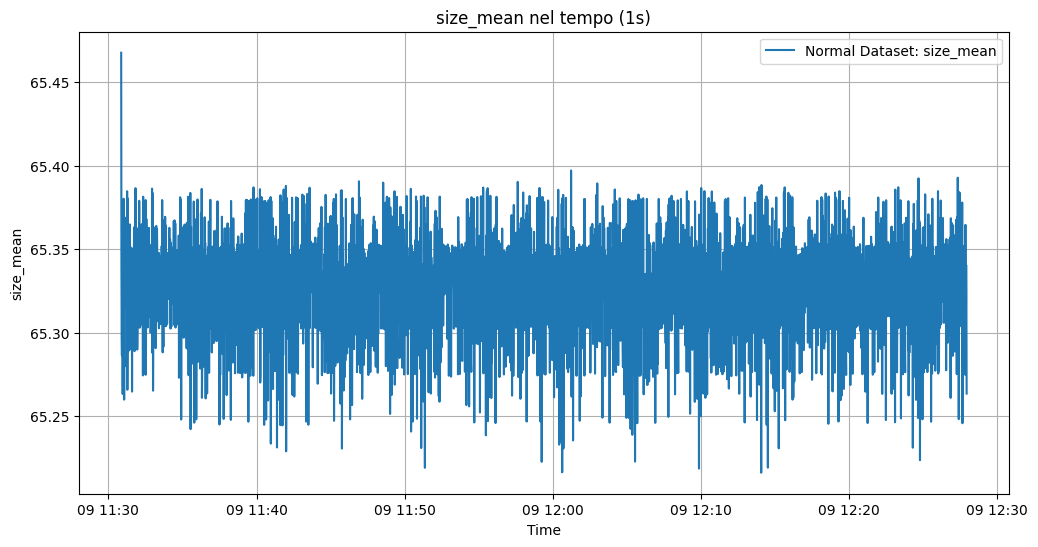

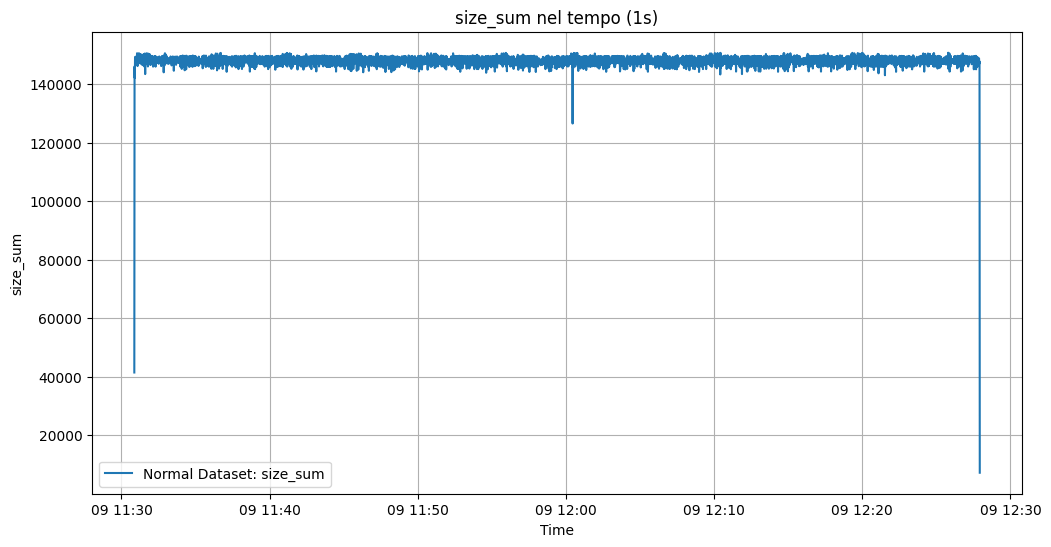

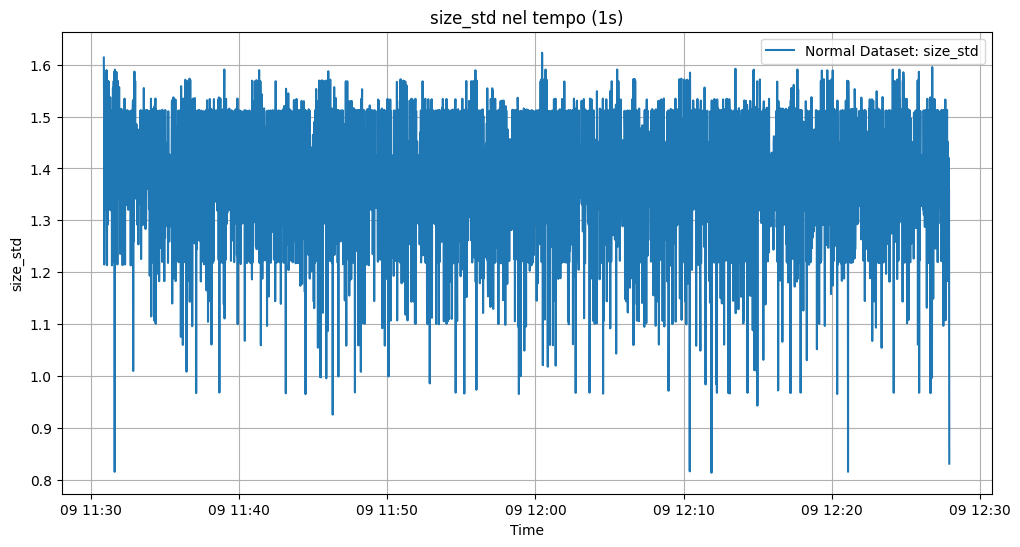

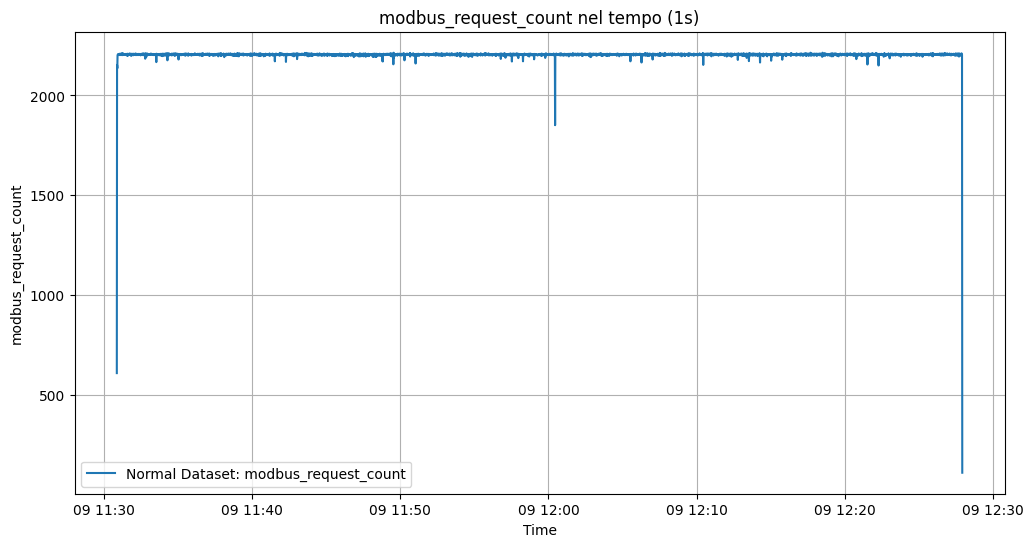

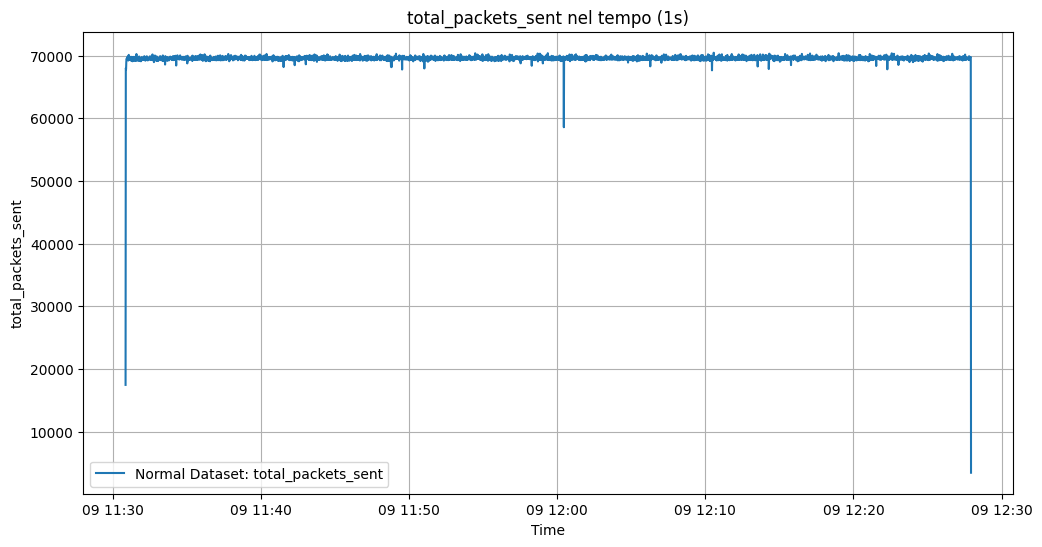

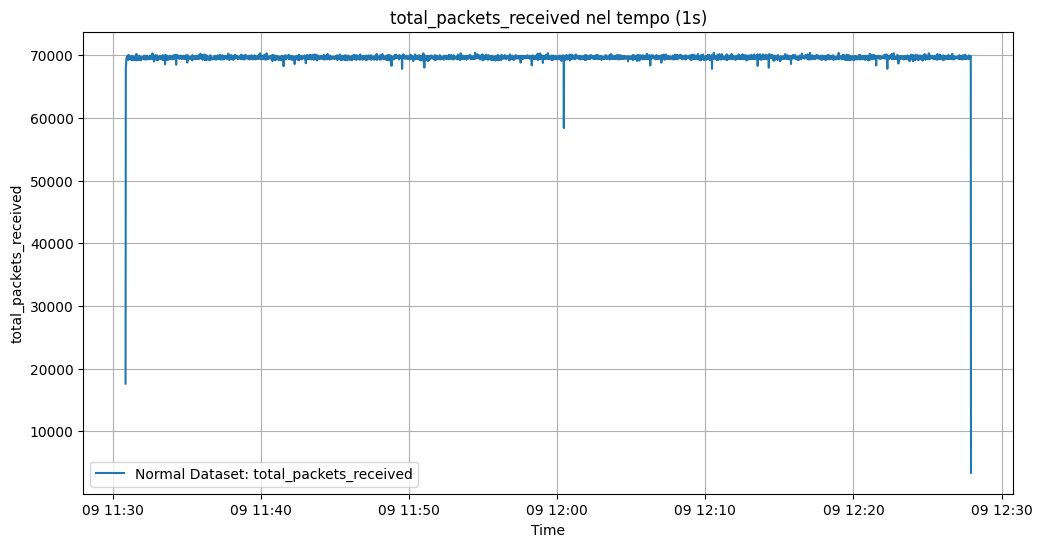

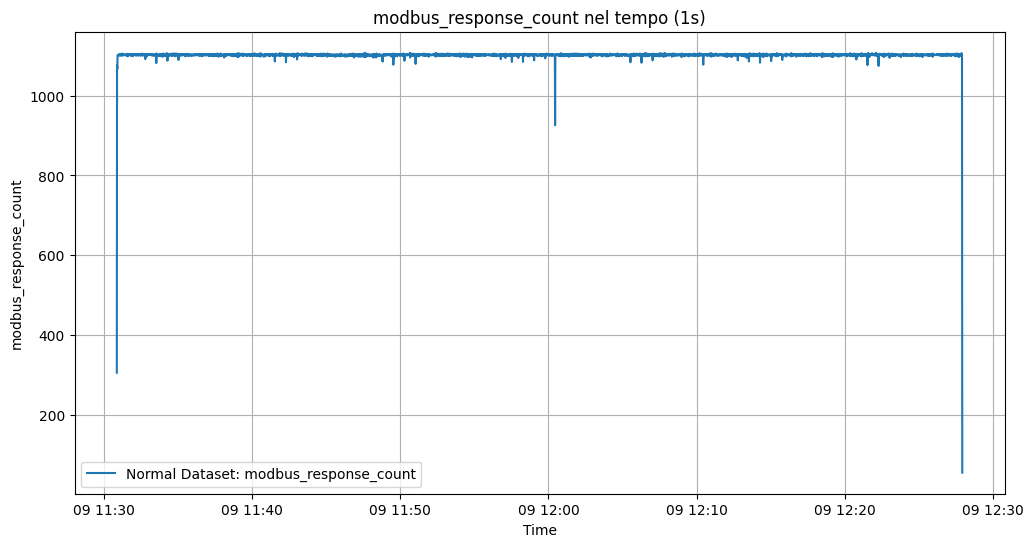

Preprocessing completato per il dataset normale.


In [7]:
# Dataset normale
normal_file = os.path.join(network_selected_folder, 'normal.csv')  # File selezionato
normal_output = os.path.join(network_selected_folder, 'processed_normal_resampled.csv')  # Percorso di output

# Preprocessa il dataset normale
normal_resampled = preprocess_and_resample(
    file_path=normal_file,
    output_path=normal_output,
    time_column='Time',
    resample_interval='1s',
    plot_data=True,
    label="Normal Dataset"
)

print("Preprocessing completato per il dataset normale.")

Esecuzione del preprocessing per i file contenenti i dati di attacco: "attack_1.csv", "attack_2.csv", "attack_3.csv", "attack_4.csv".

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_1_resampled.csv


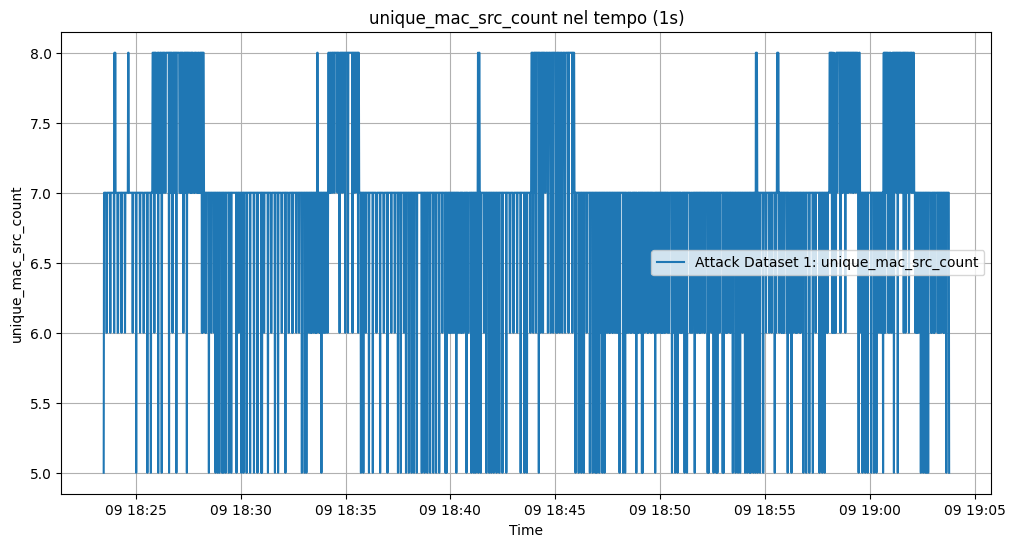

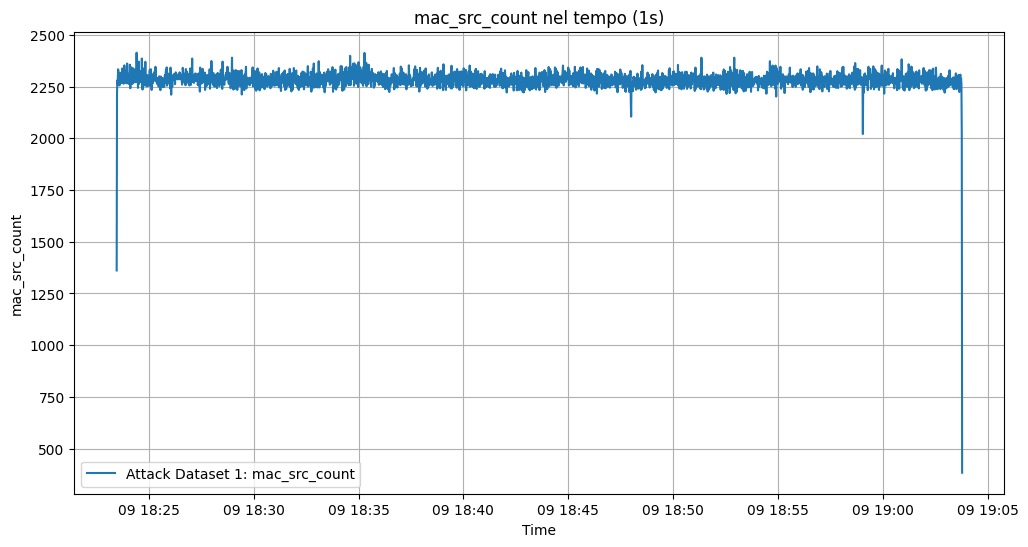

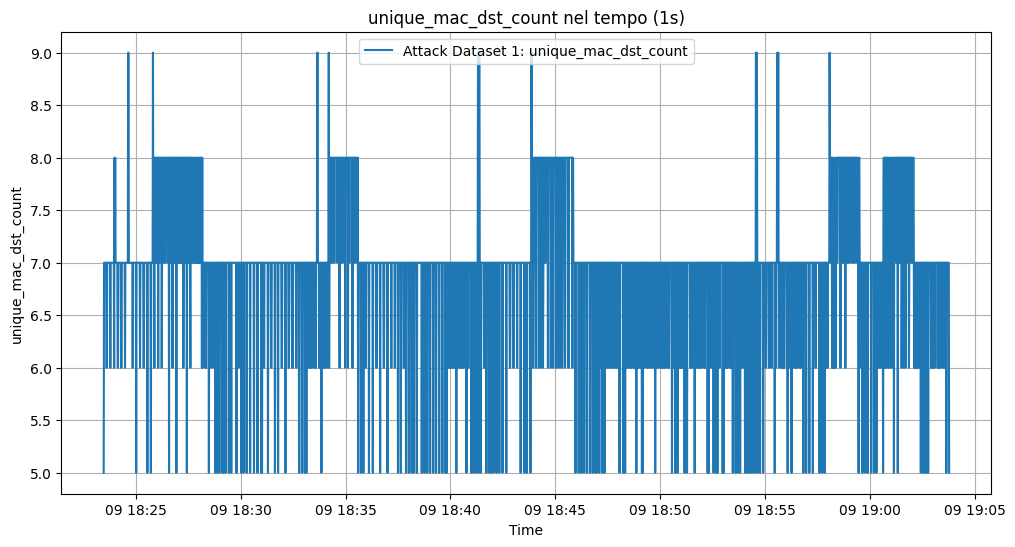

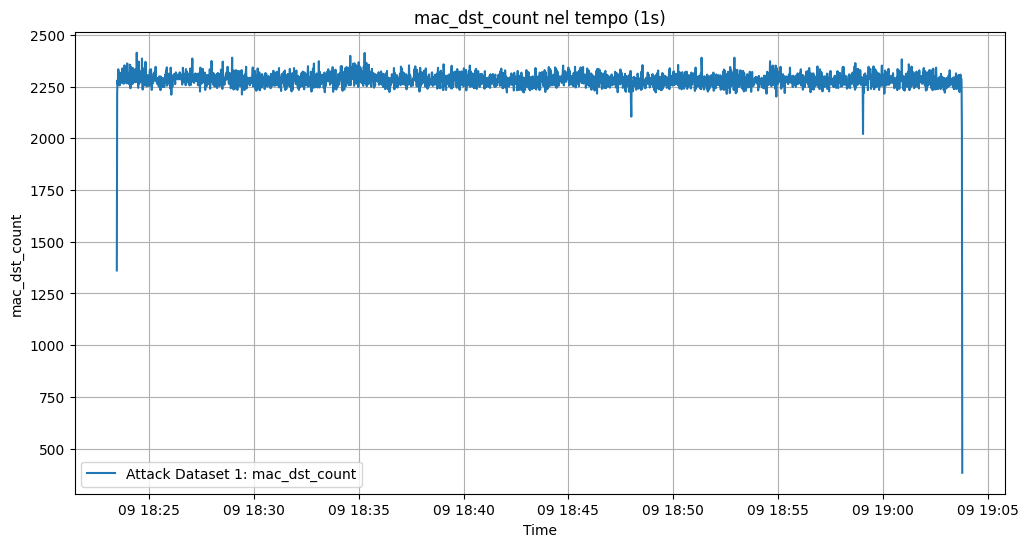

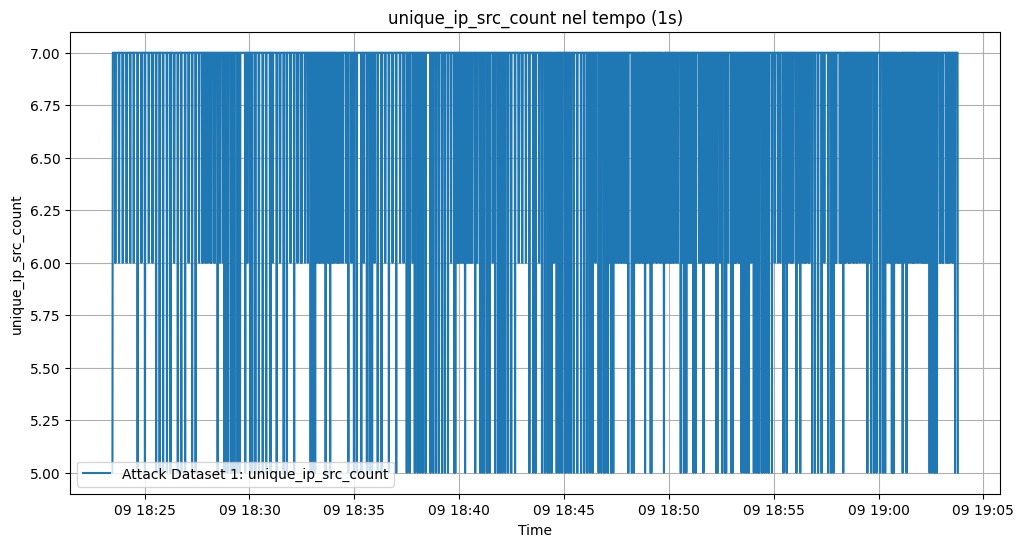

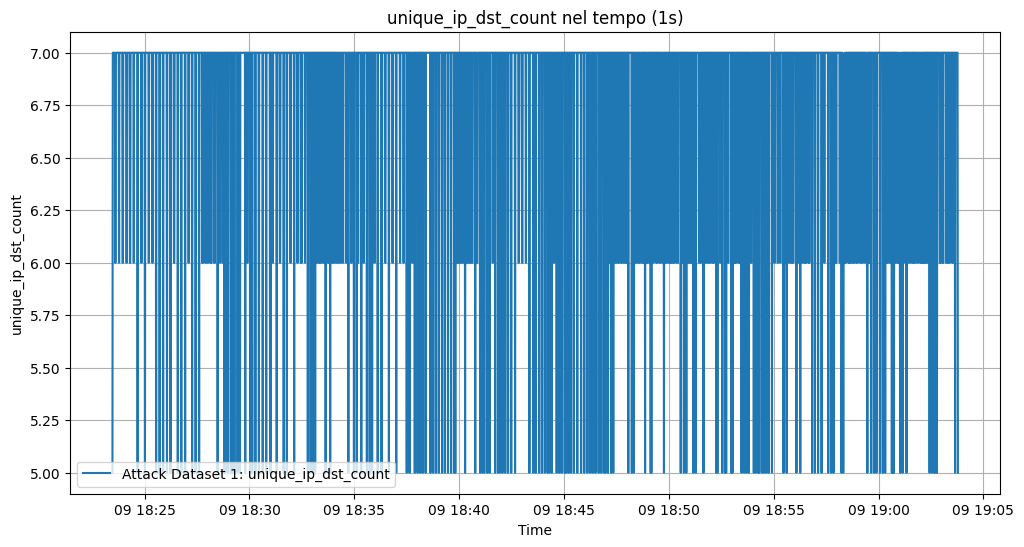

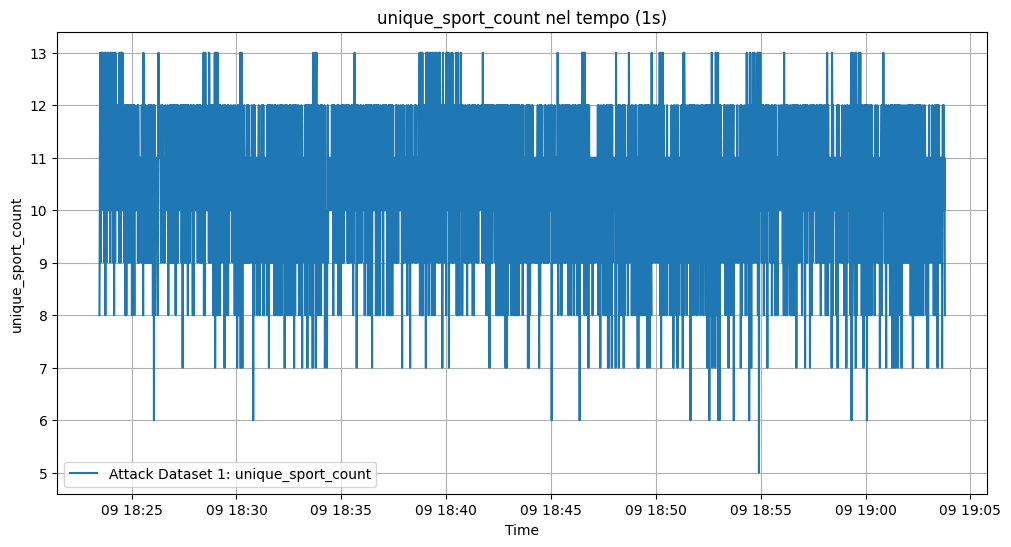

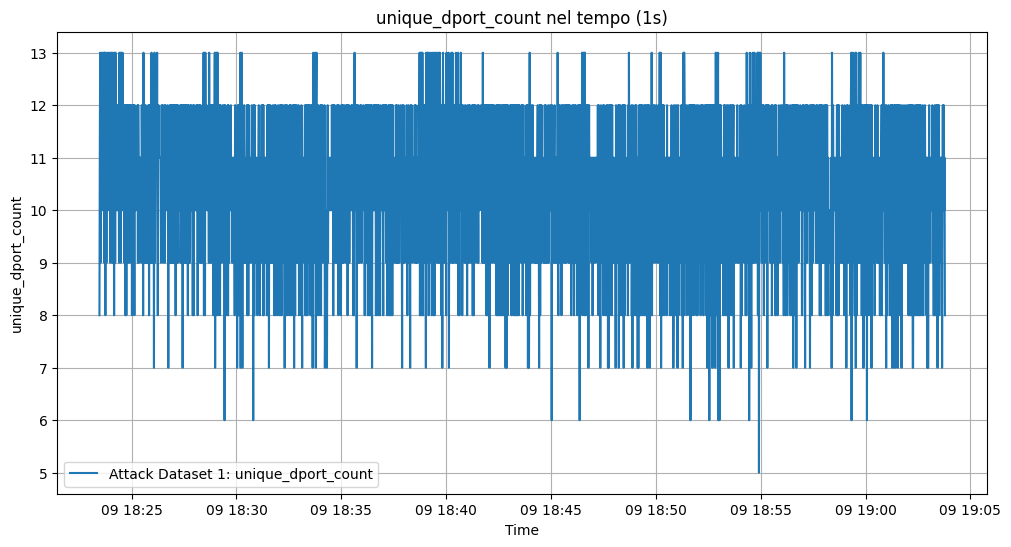

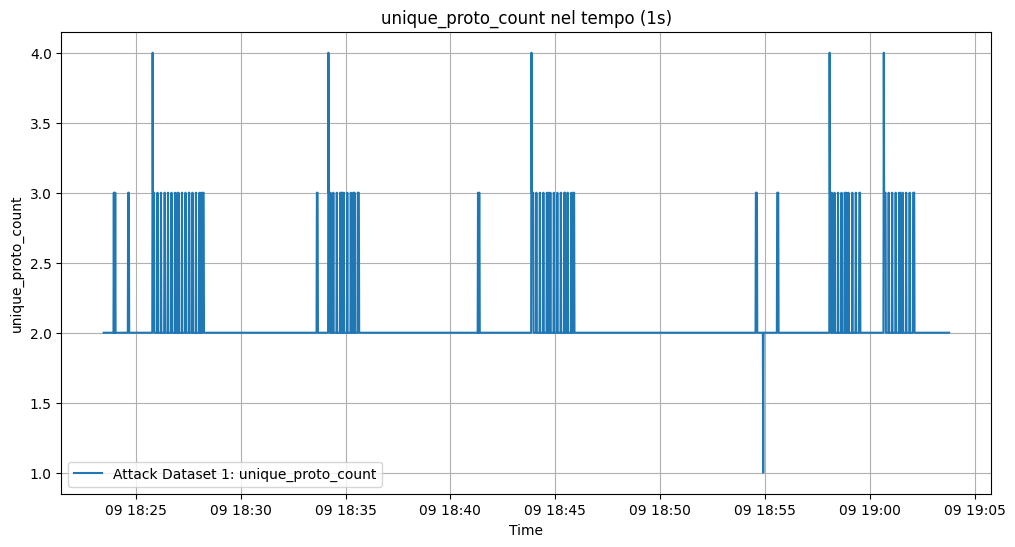

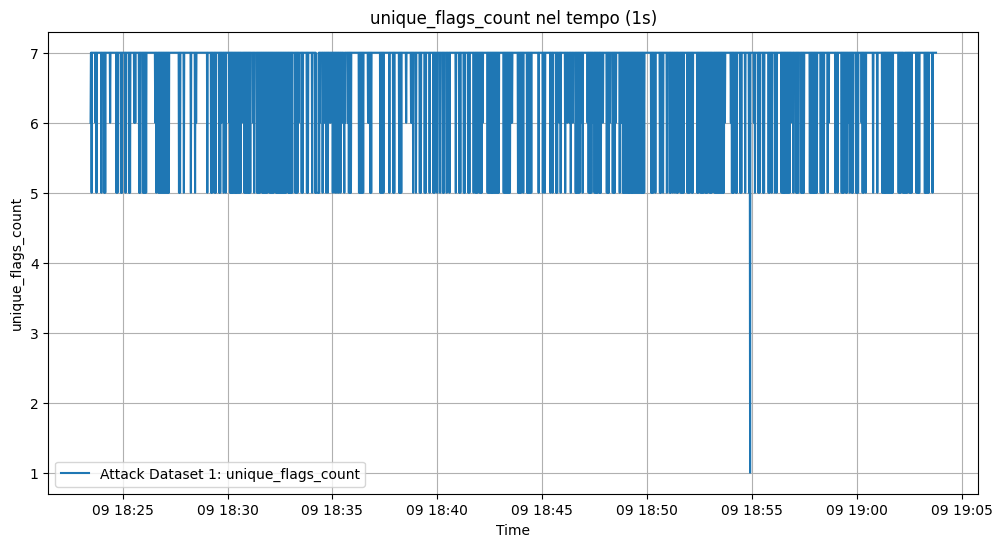

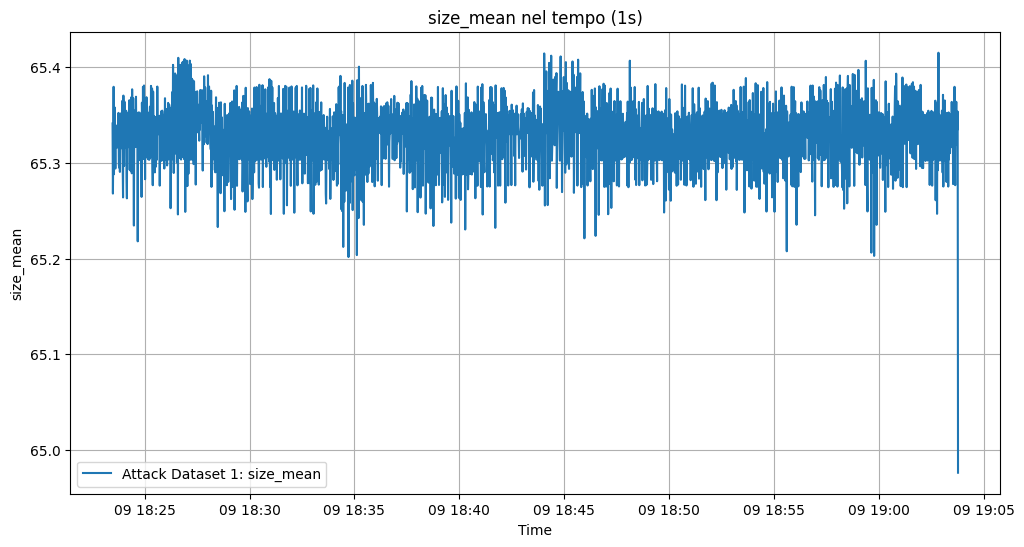

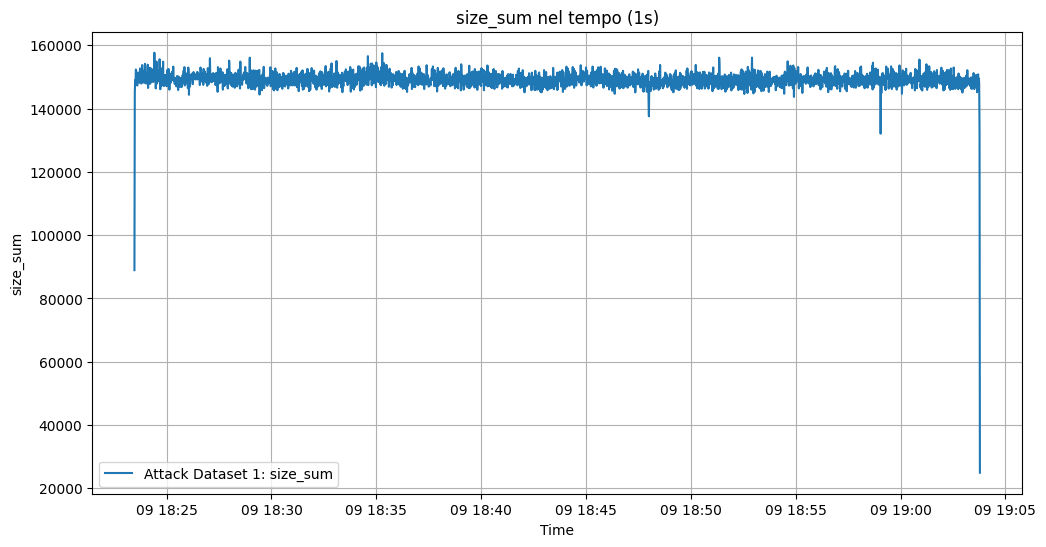

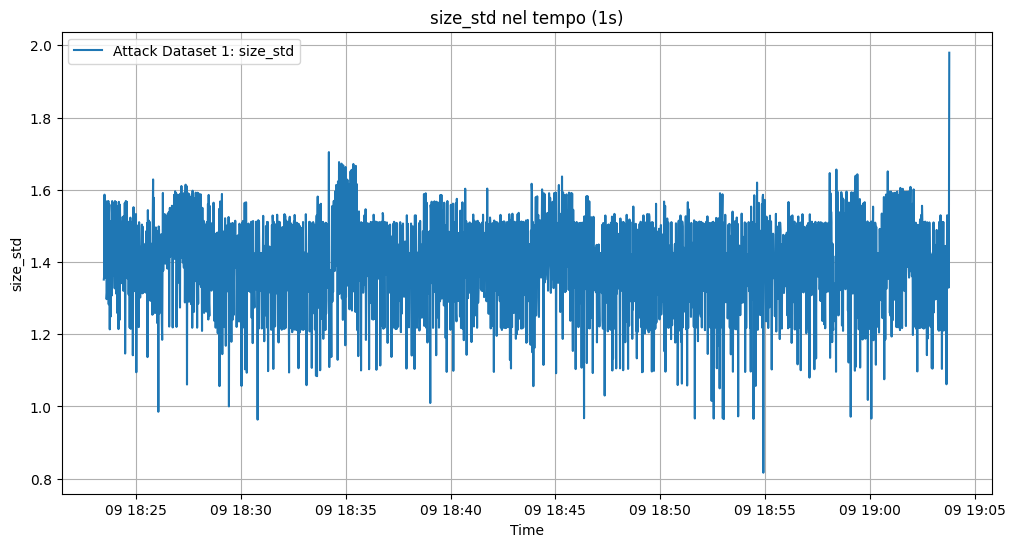

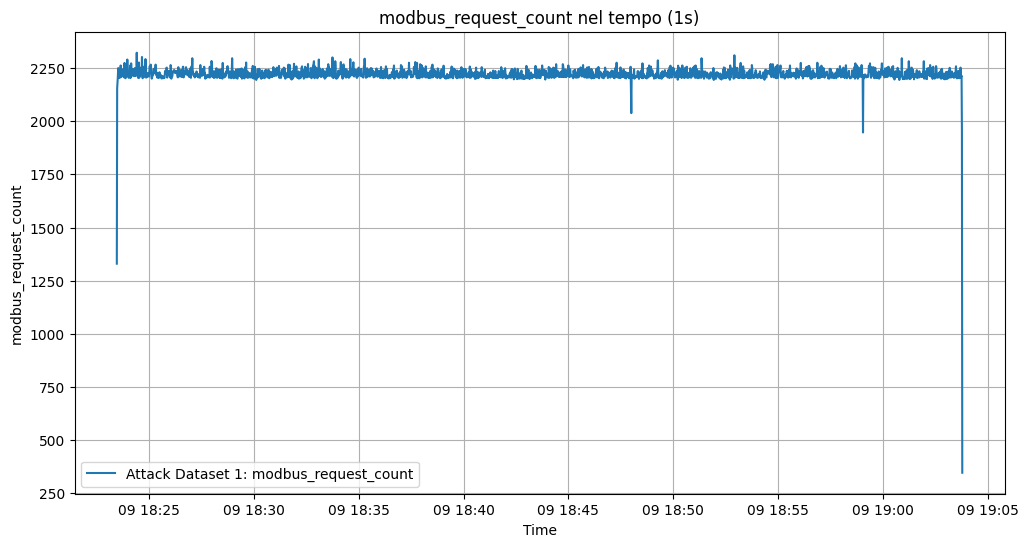

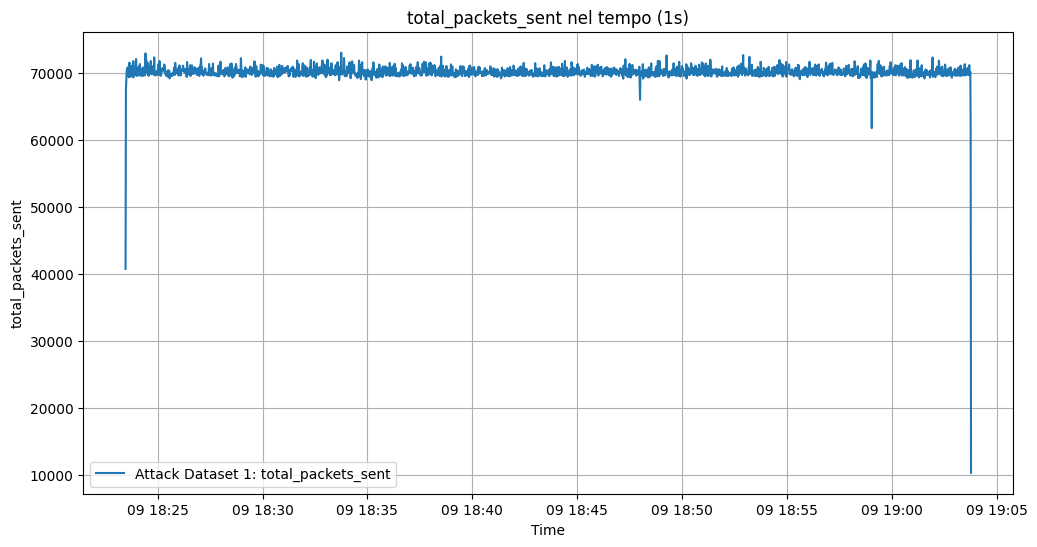

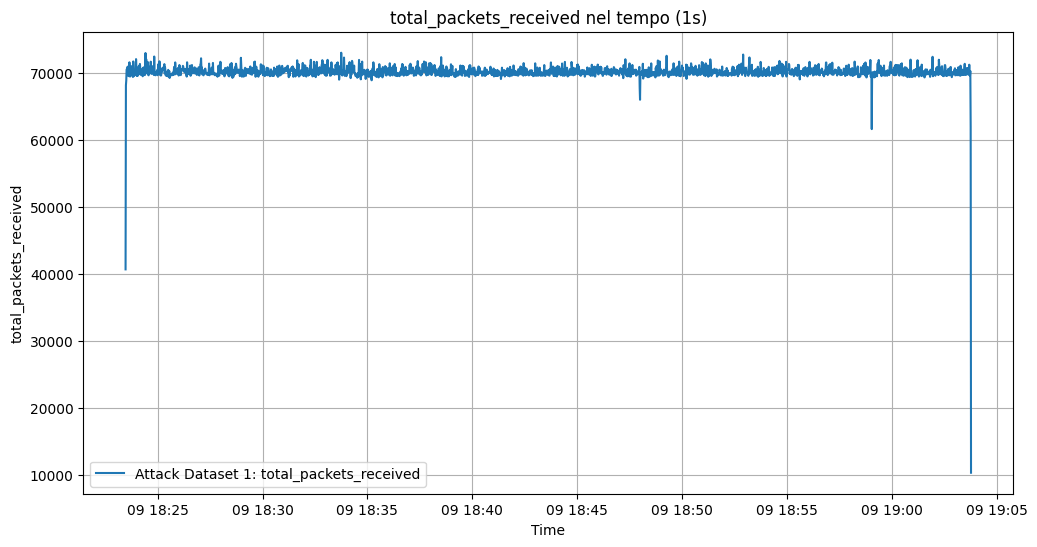

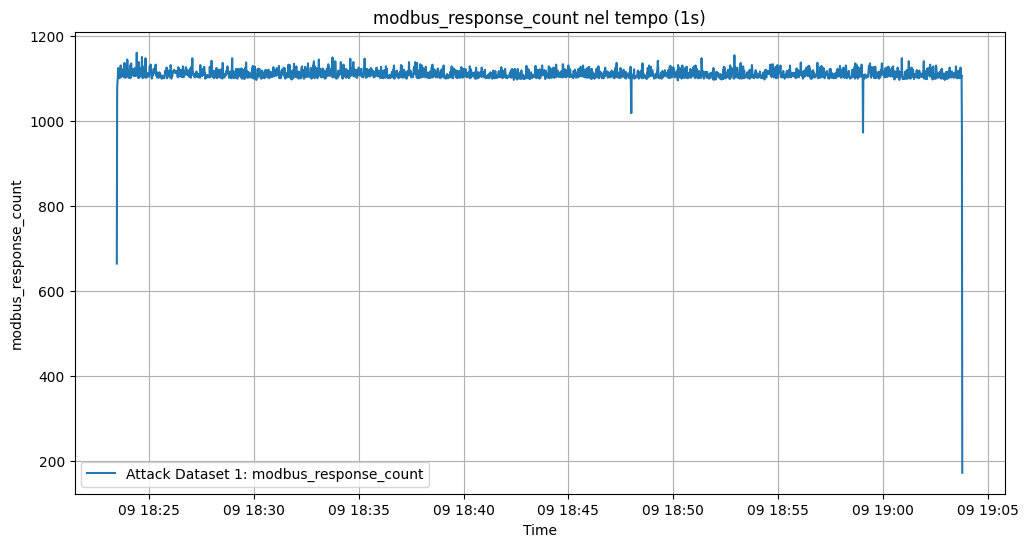

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_2_resampled.csv


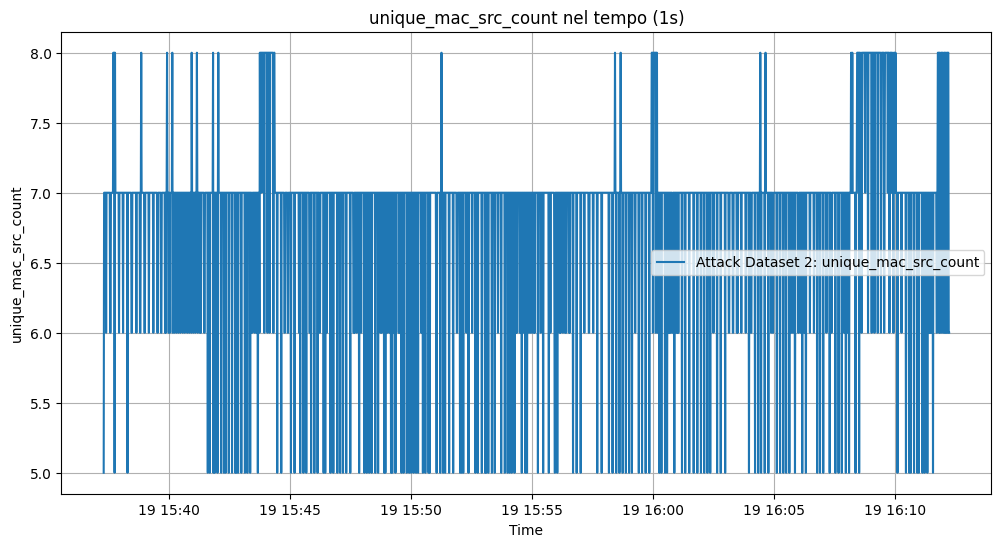

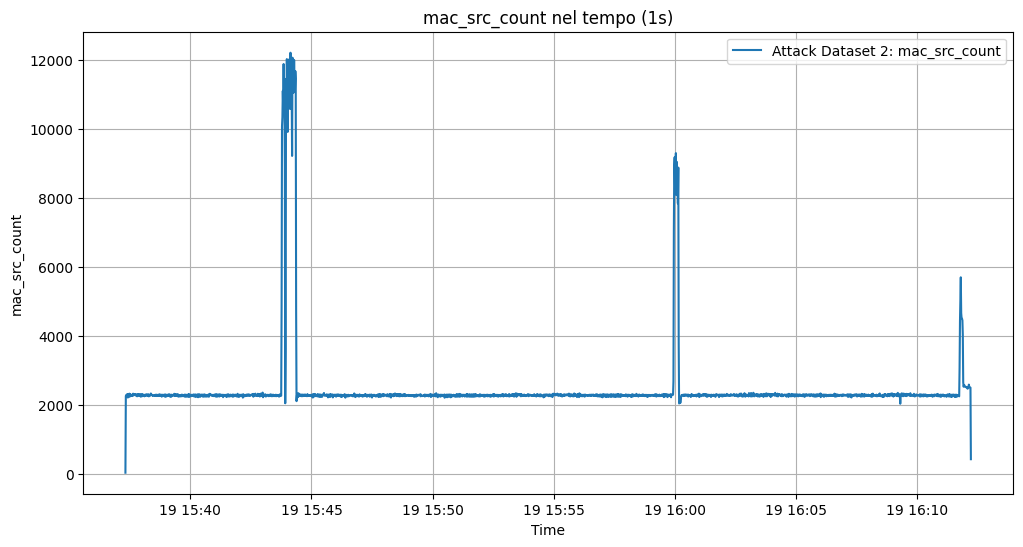

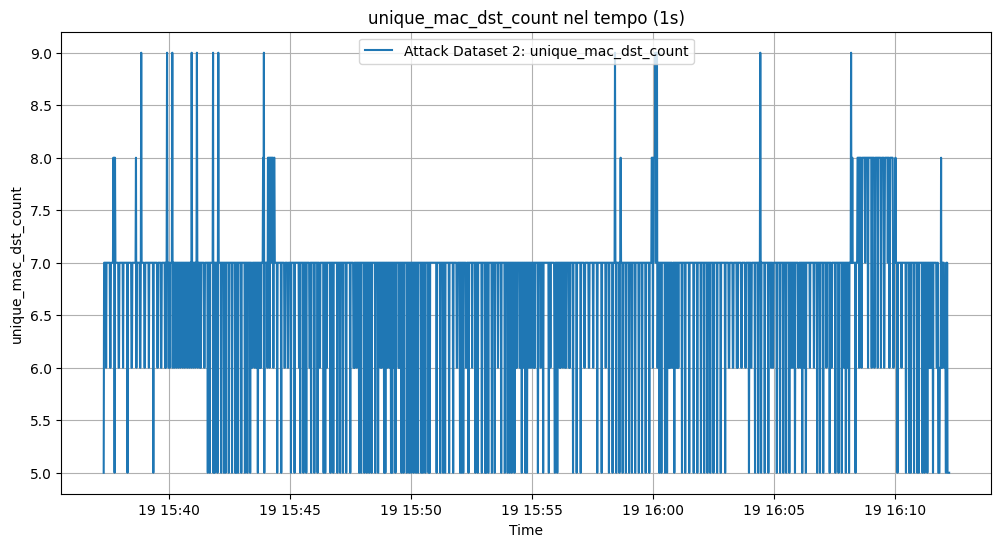

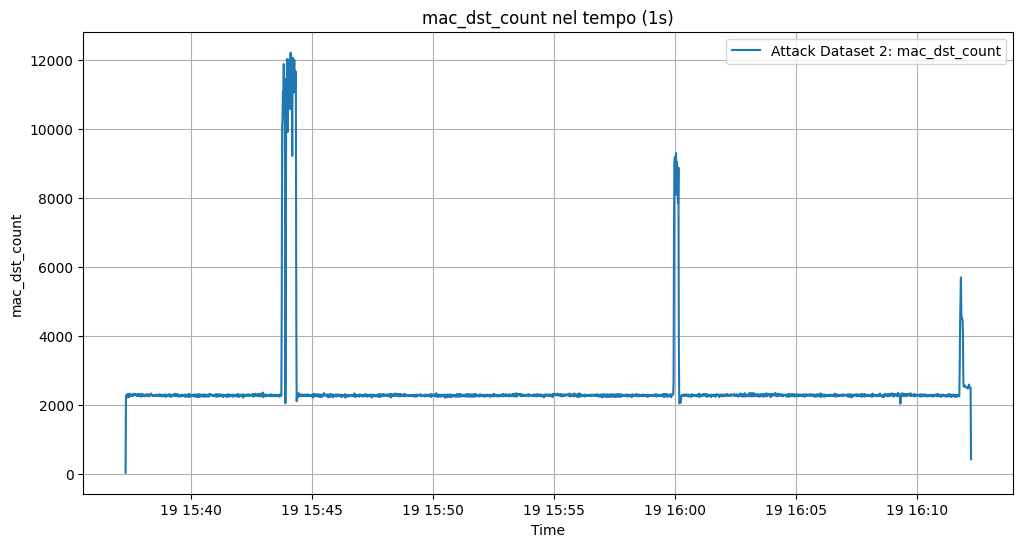

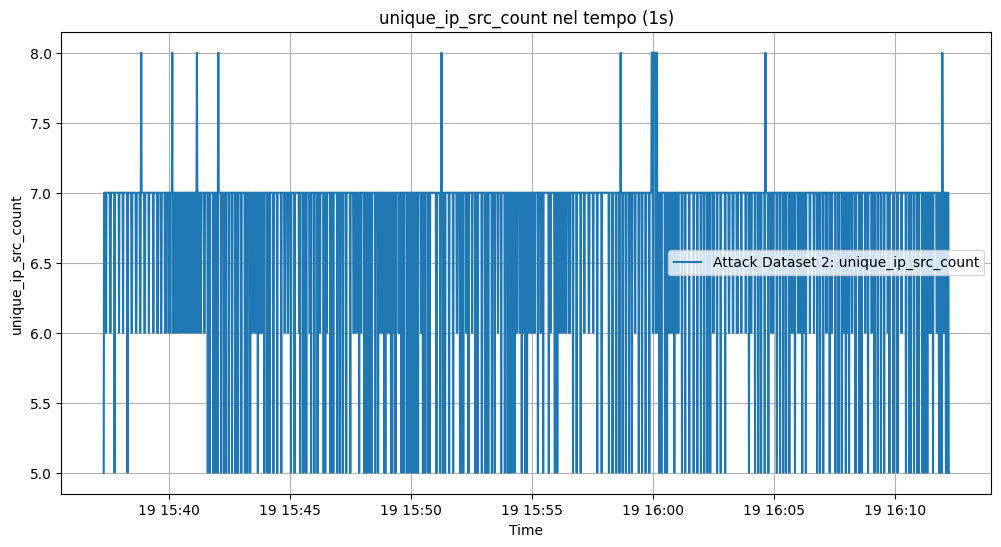

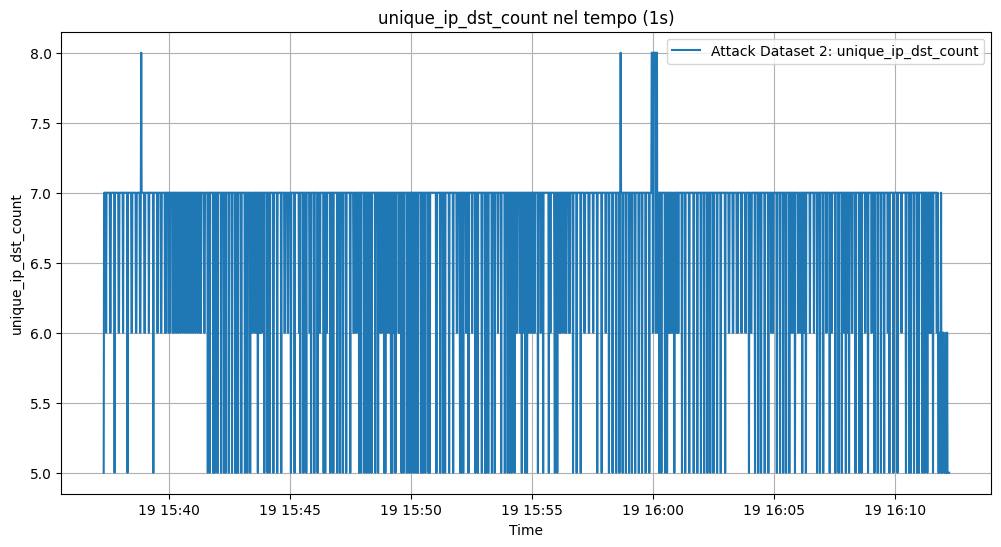

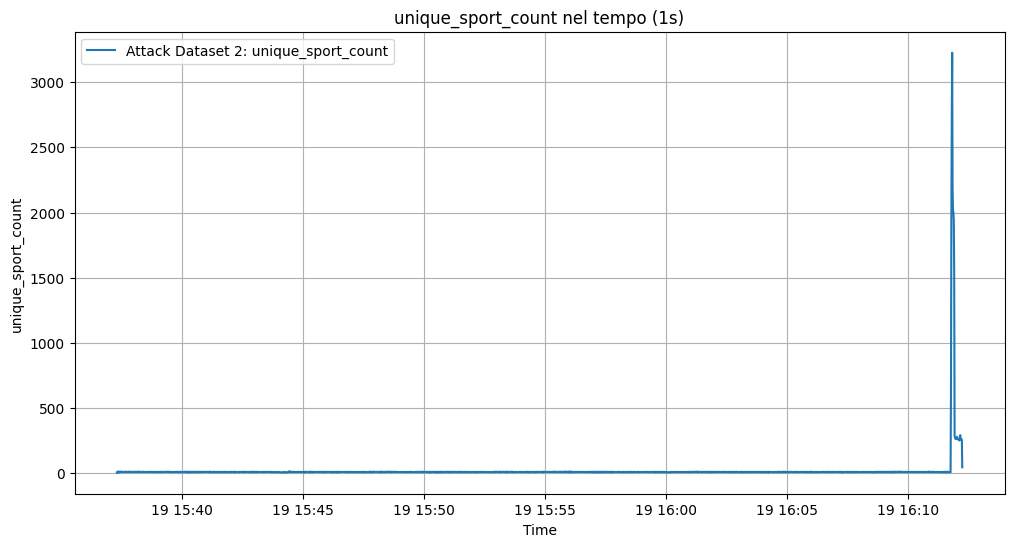

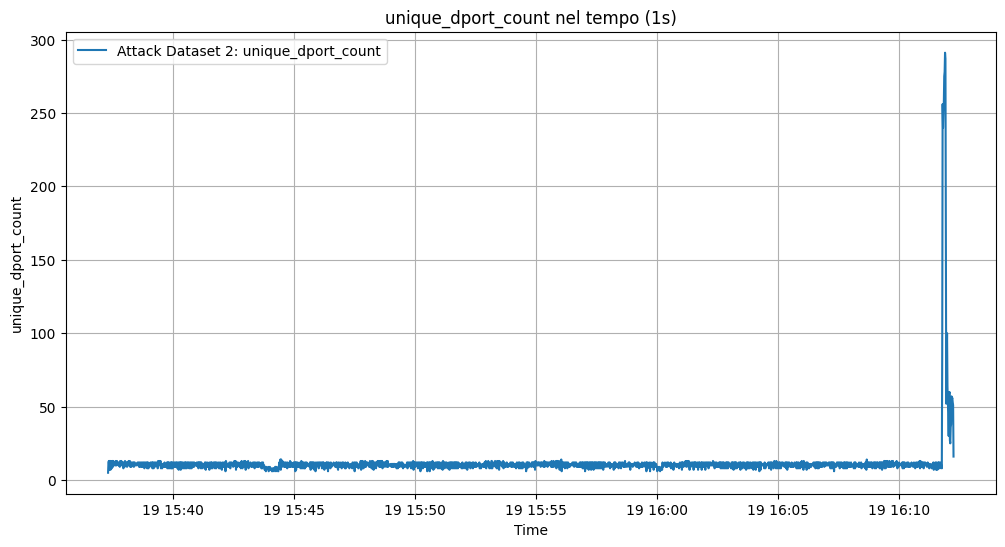

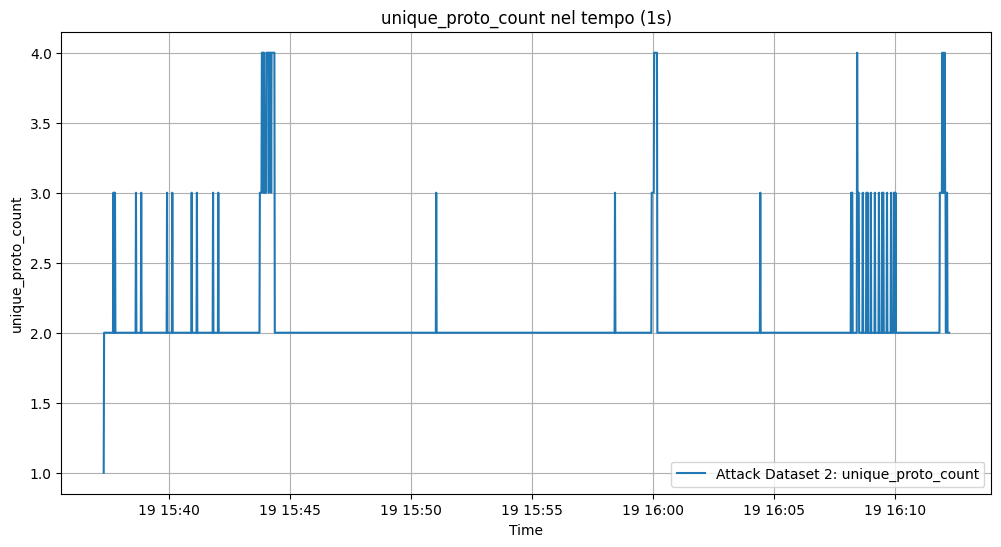

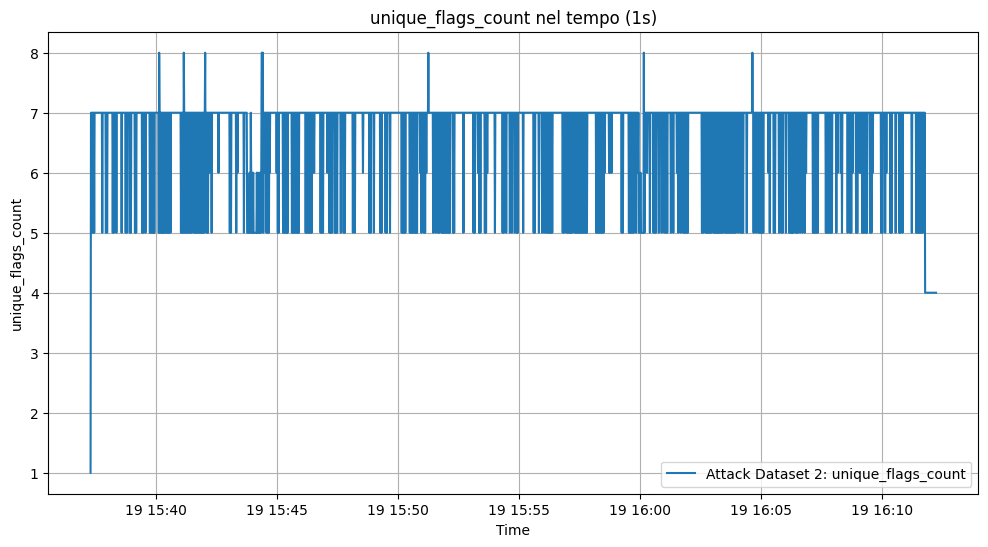

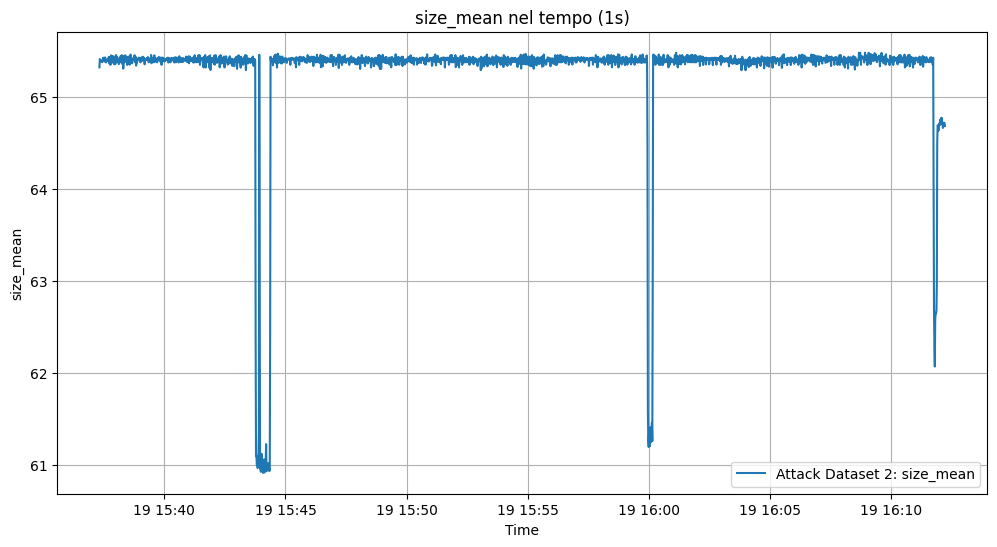

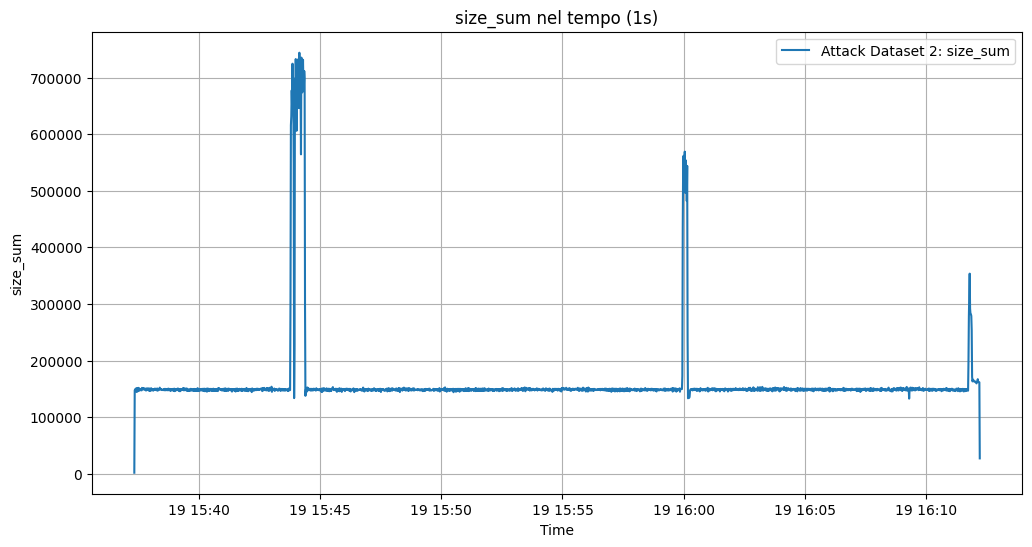

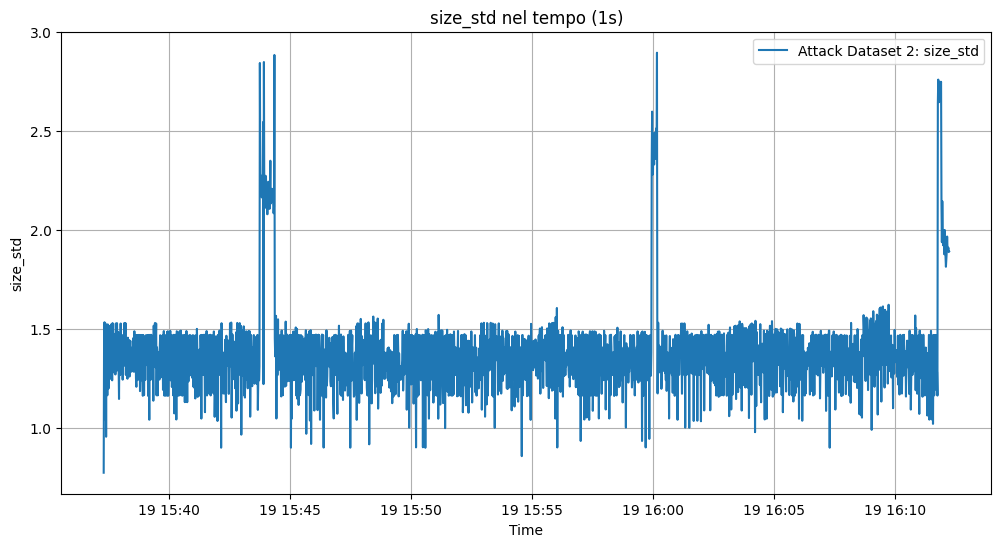

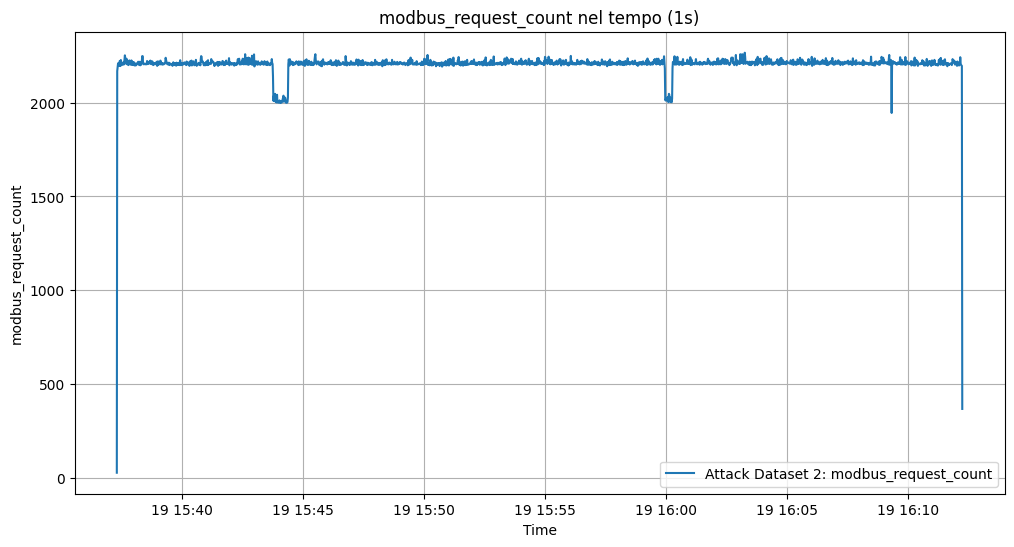

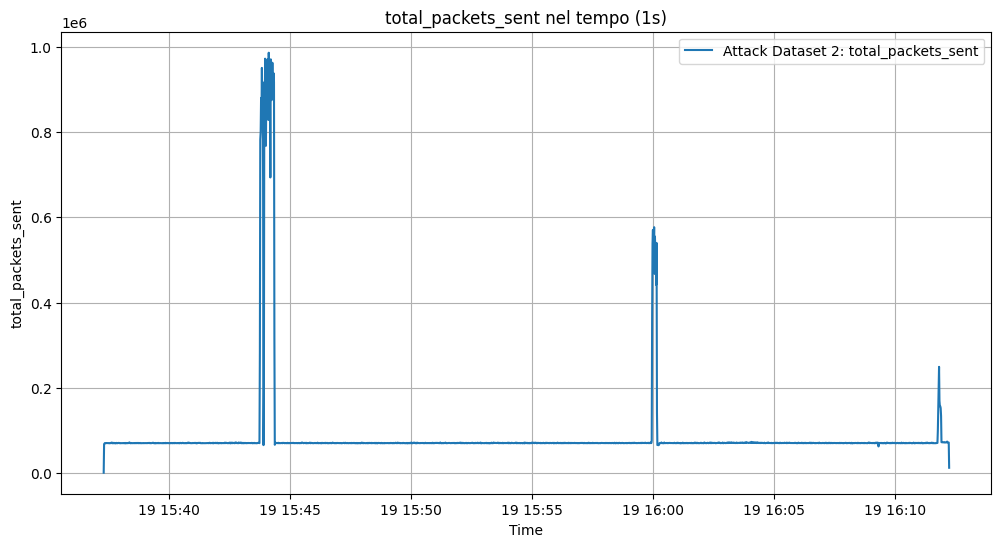

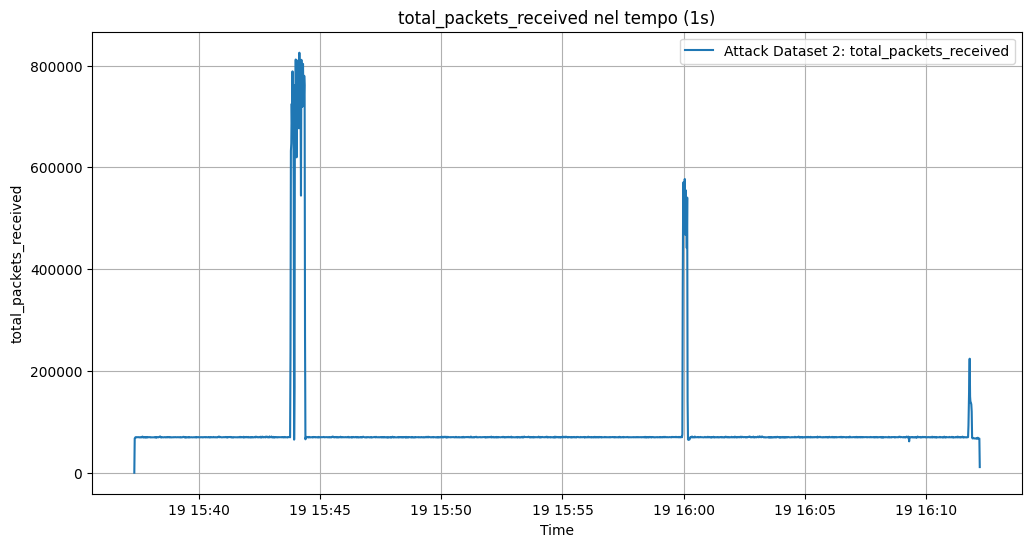

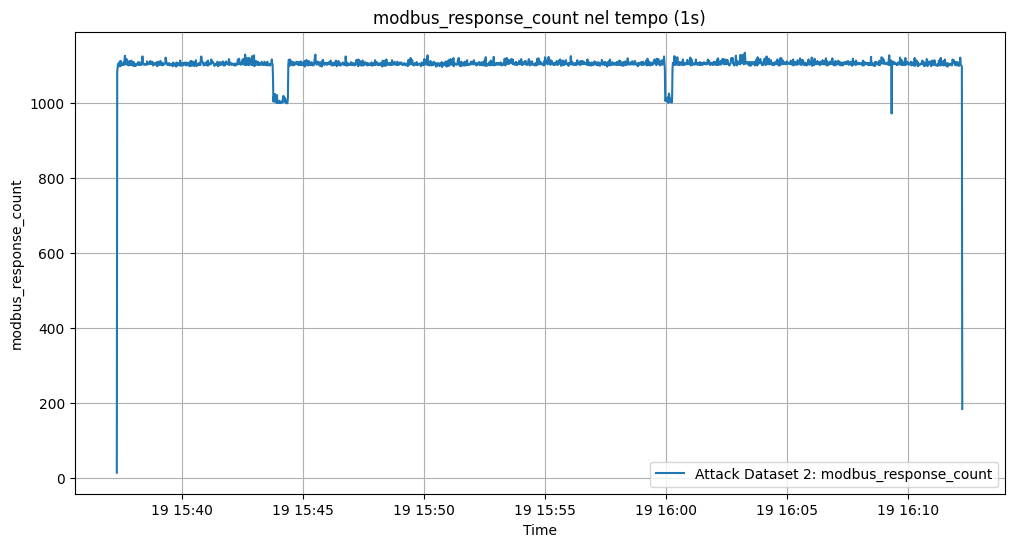

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_3_resampled.csv


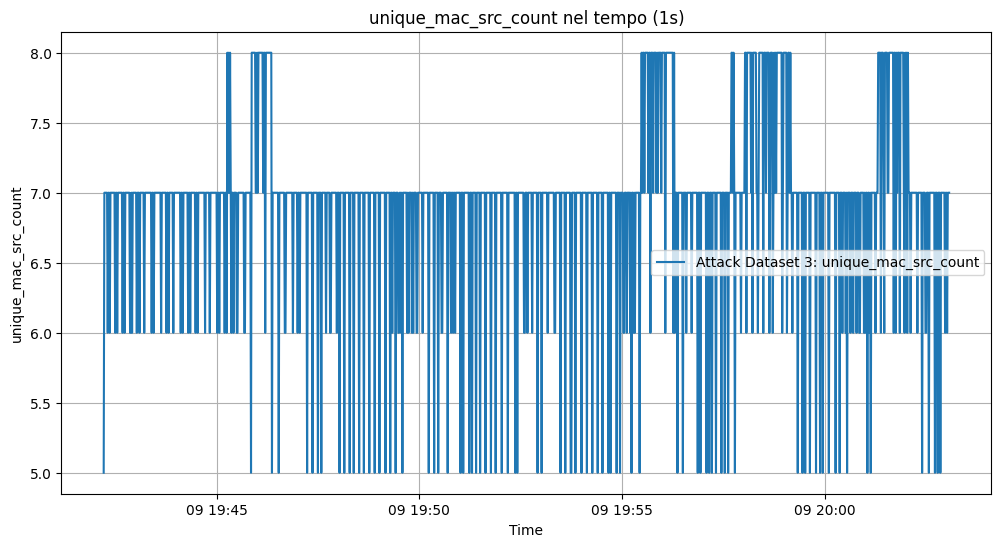

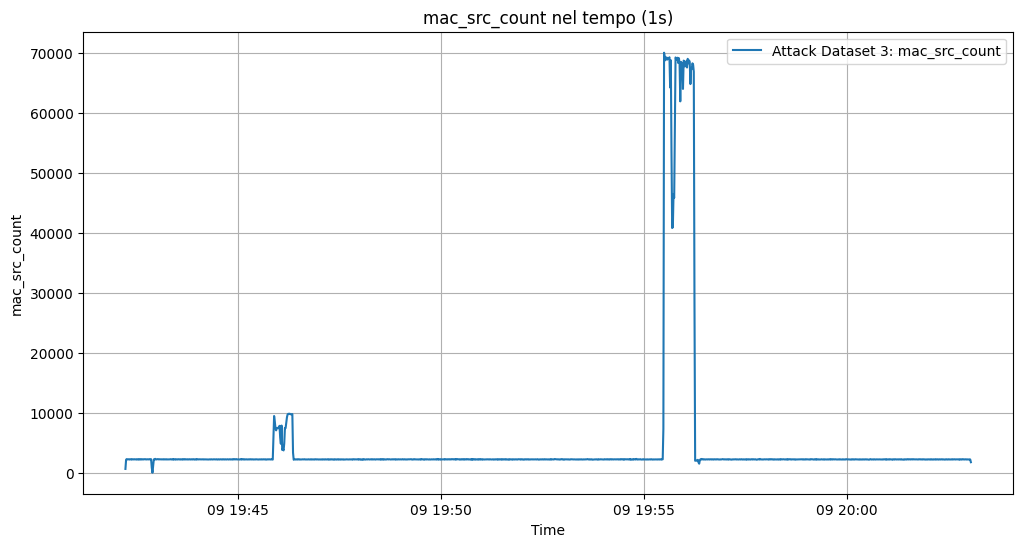

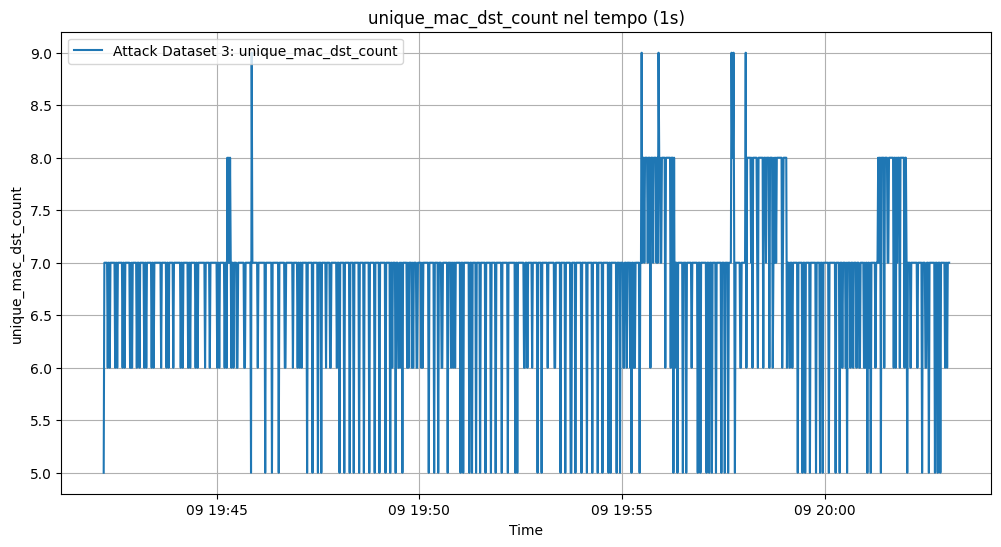

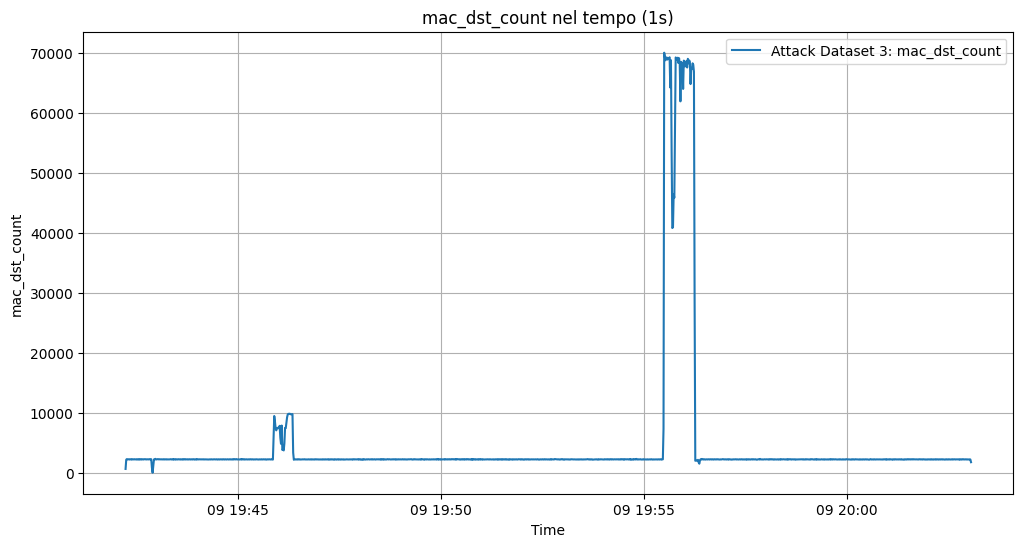

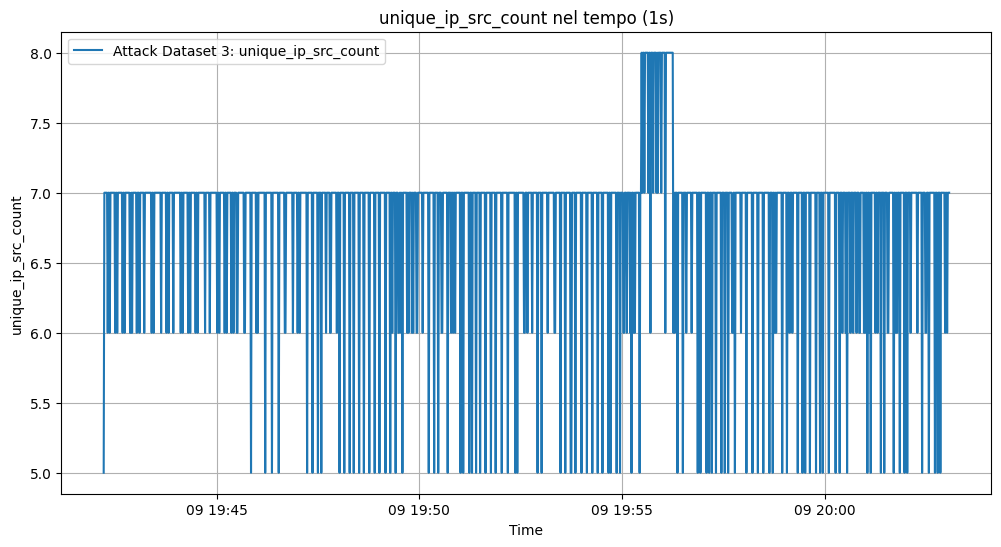

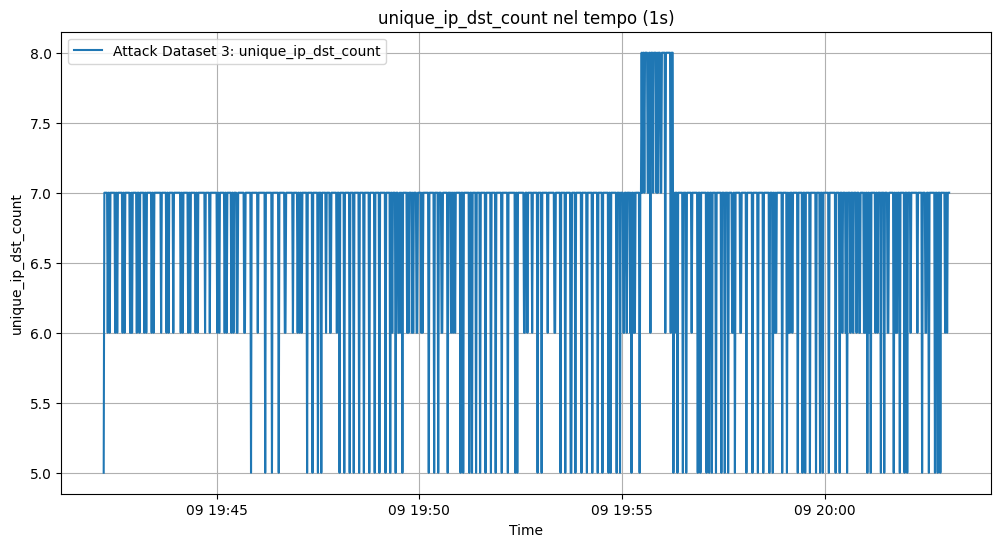

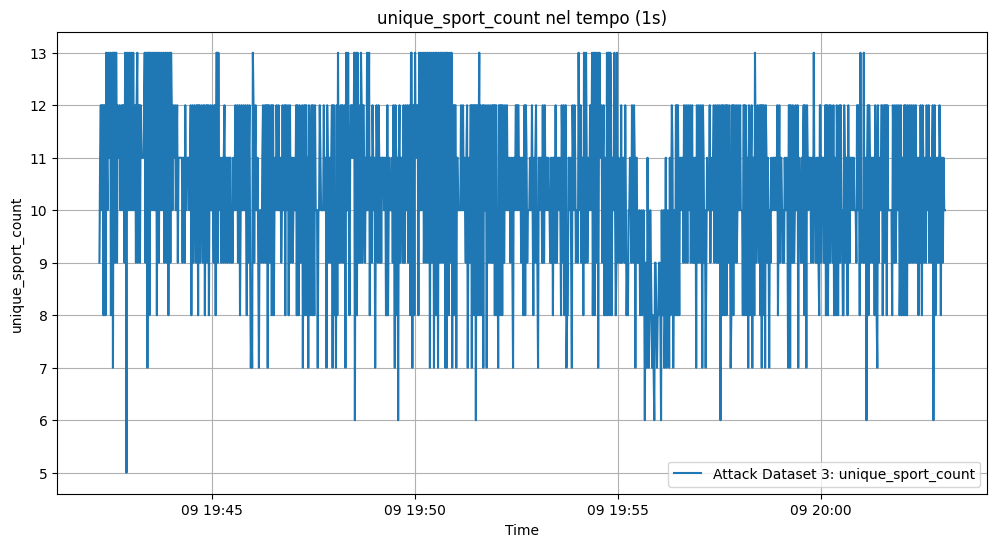

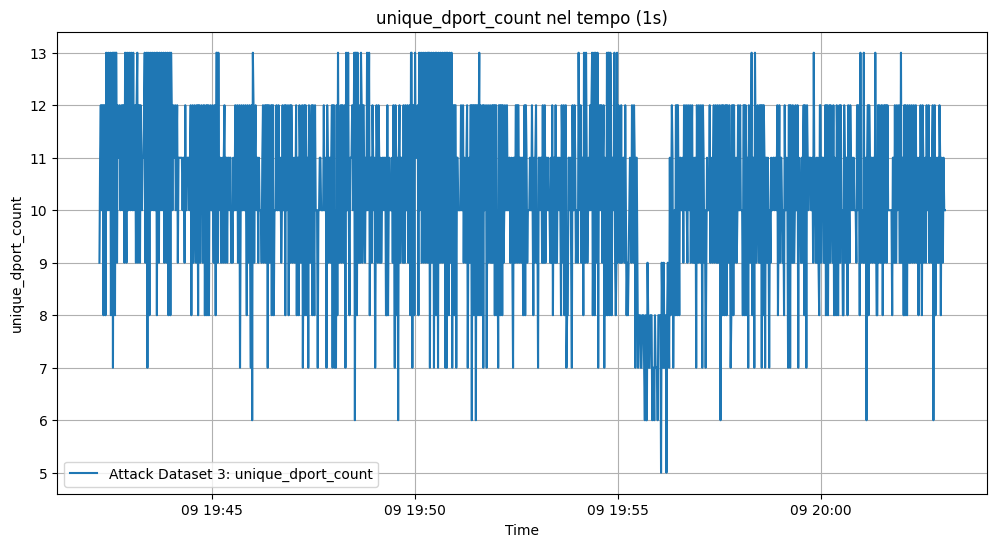

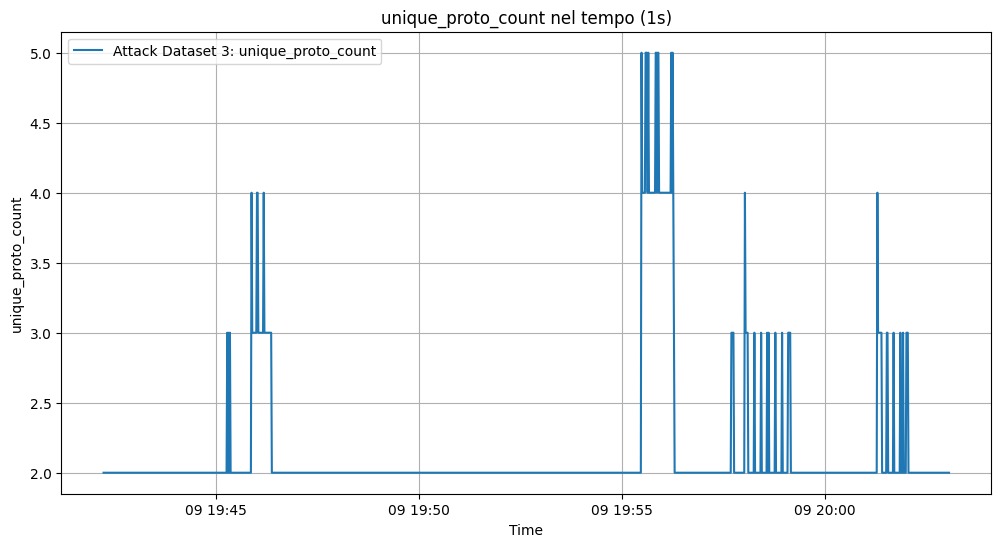

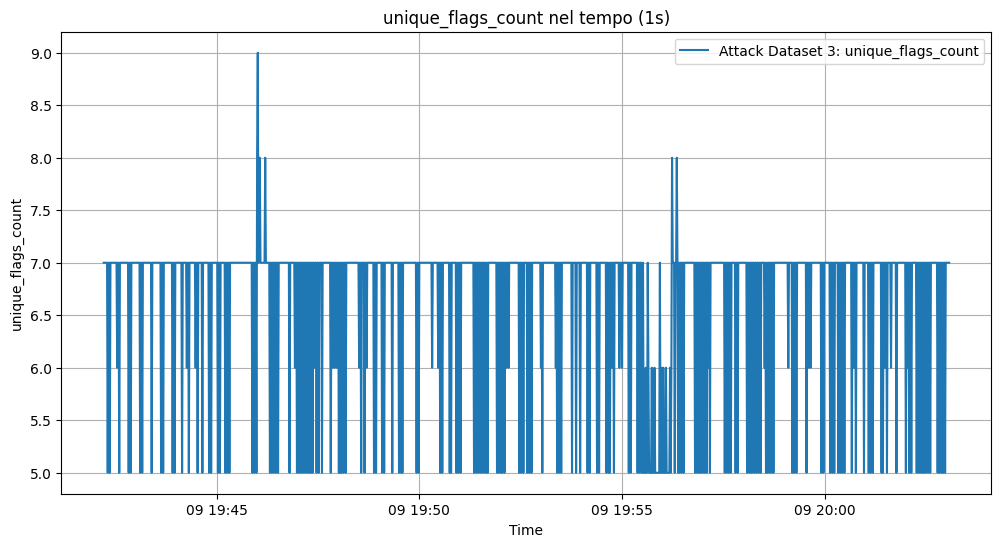

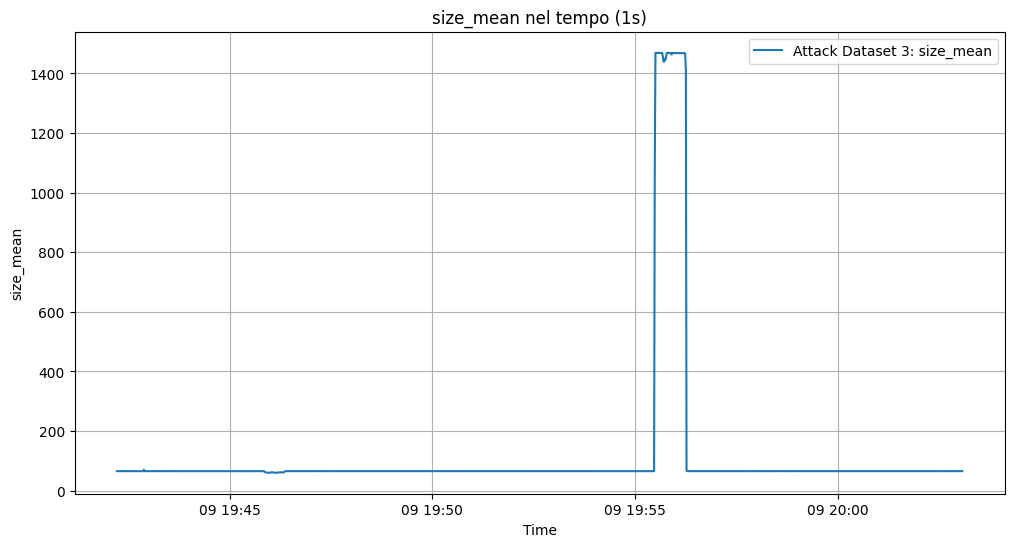

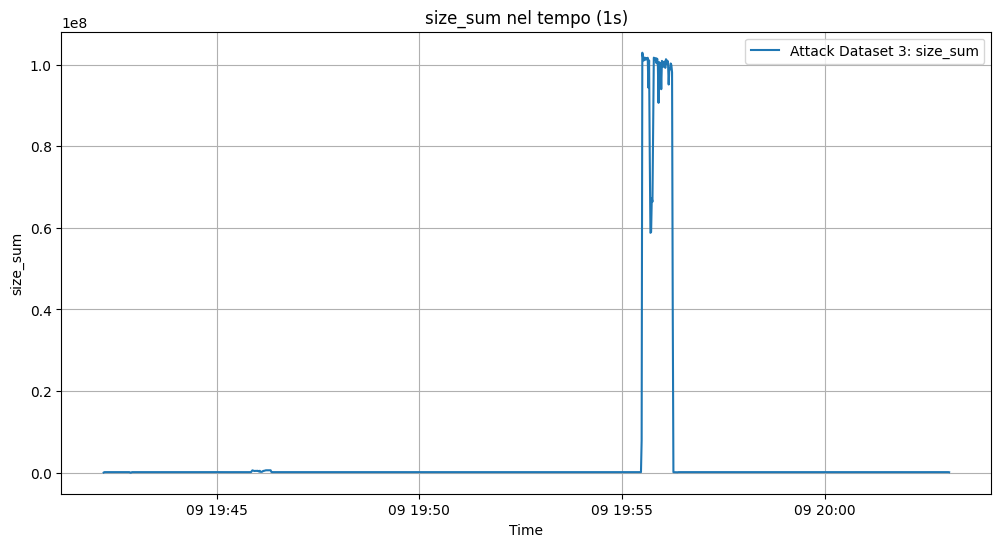

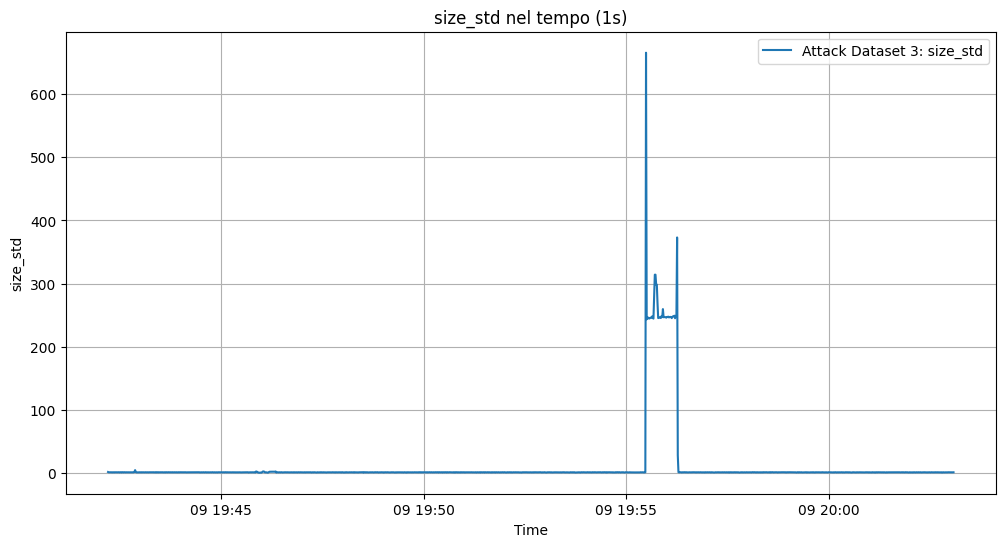

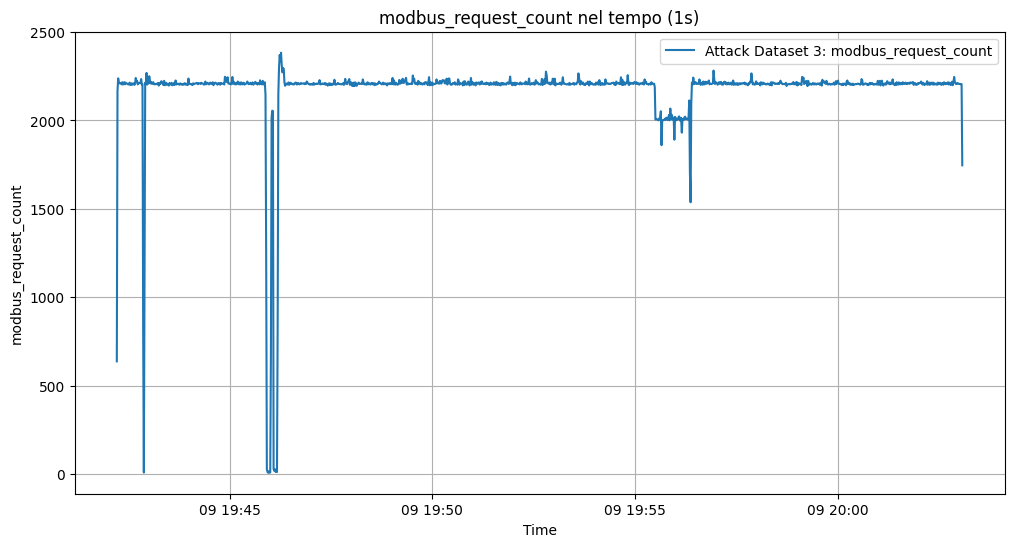

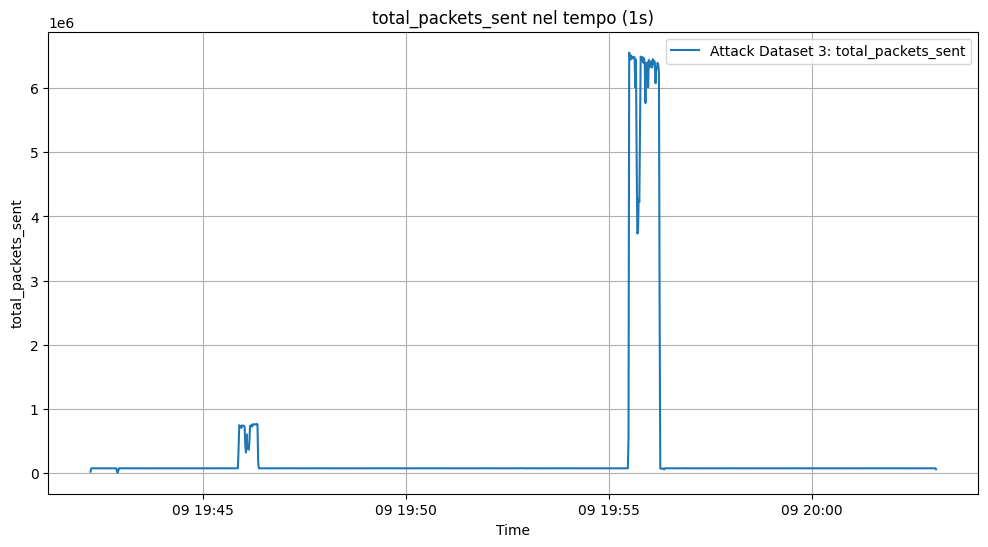

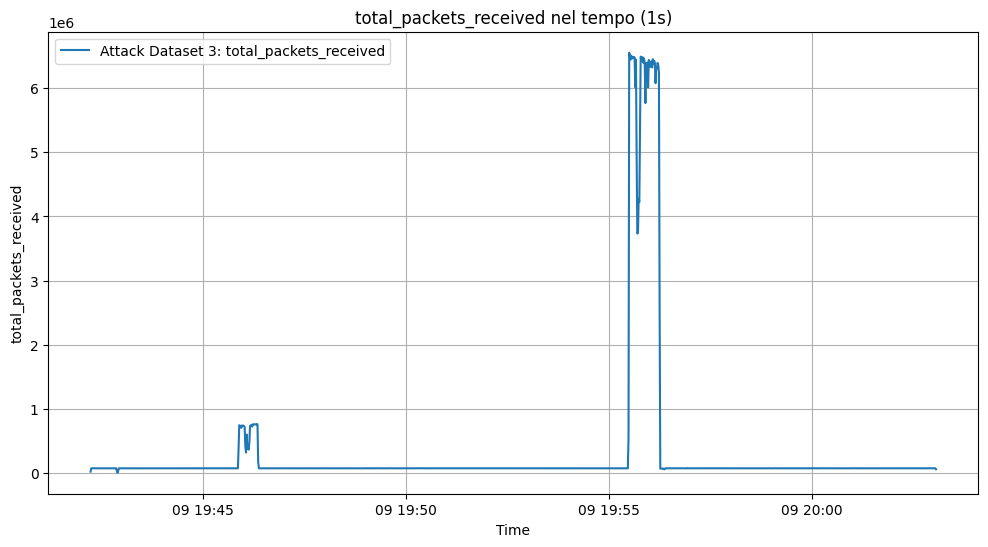

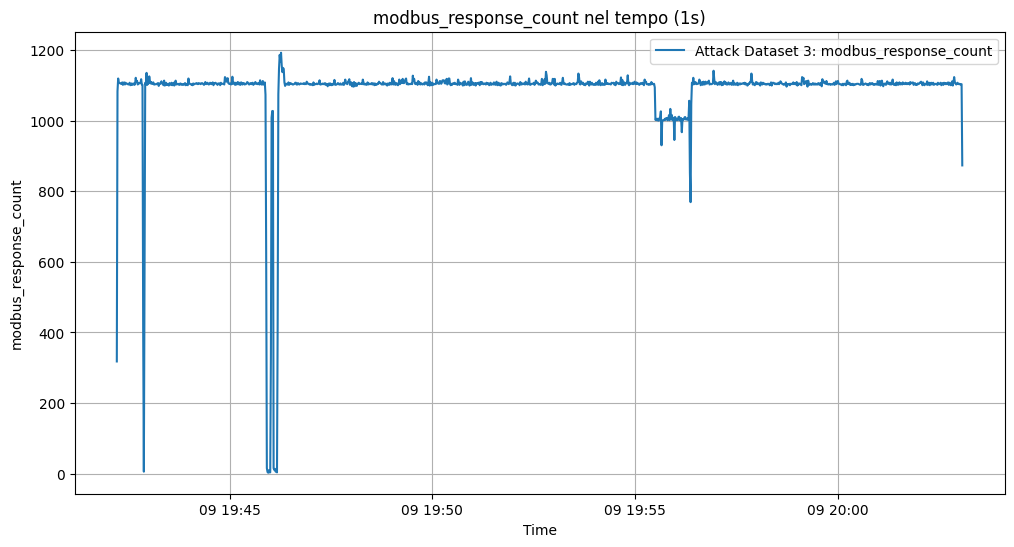

Dataset resample salvato in: /content/drive/My Drive/NetworkDataset/processed_attack_4_resampled.csv


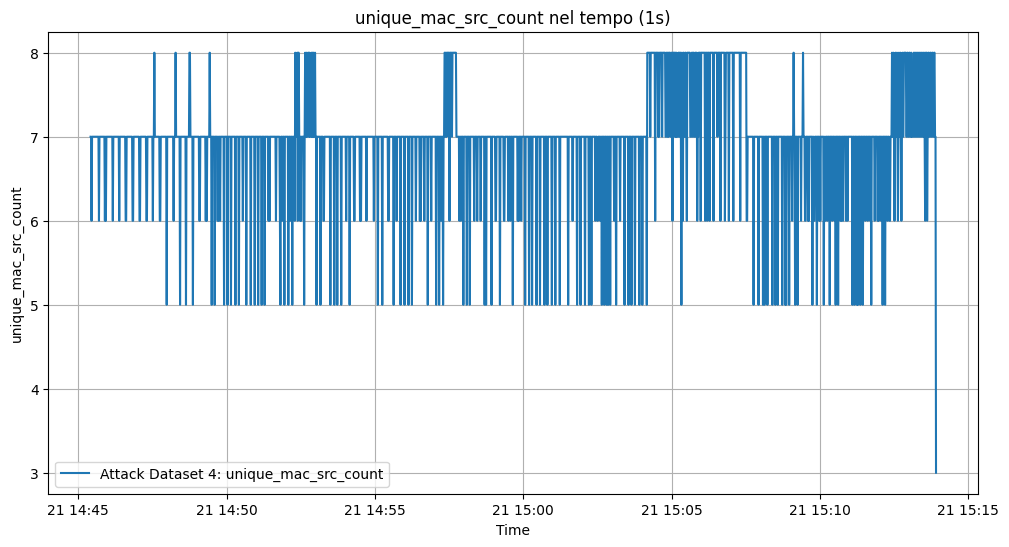

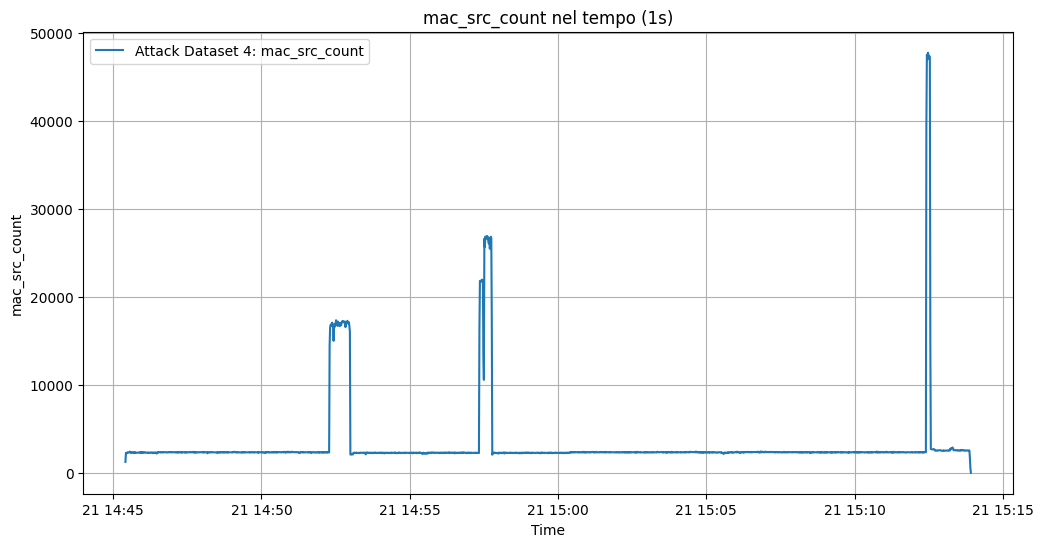

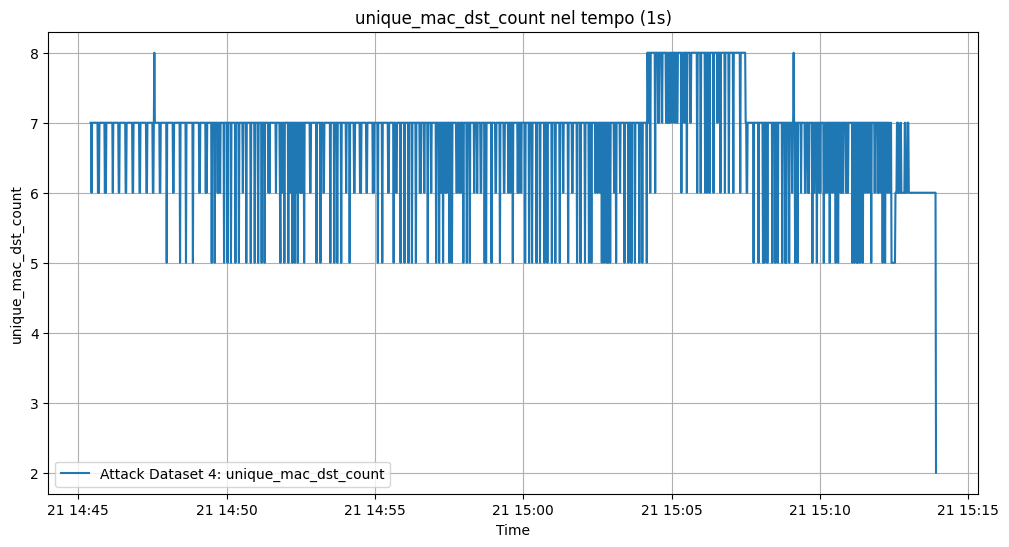

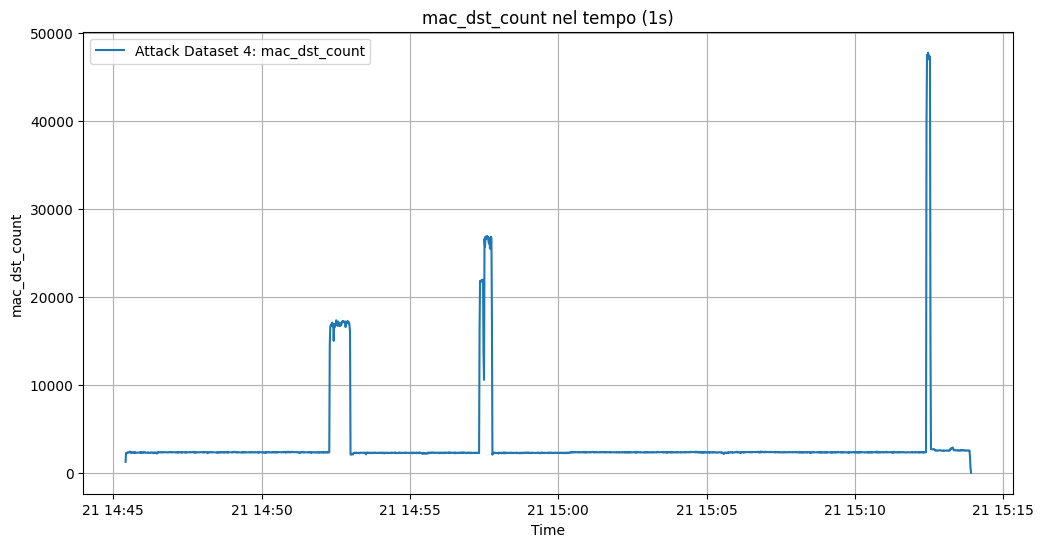

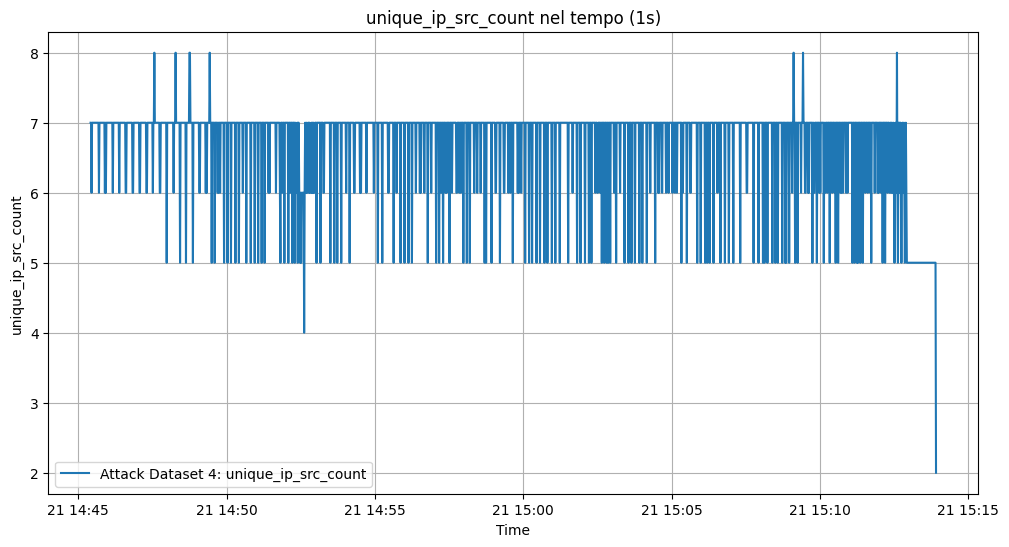

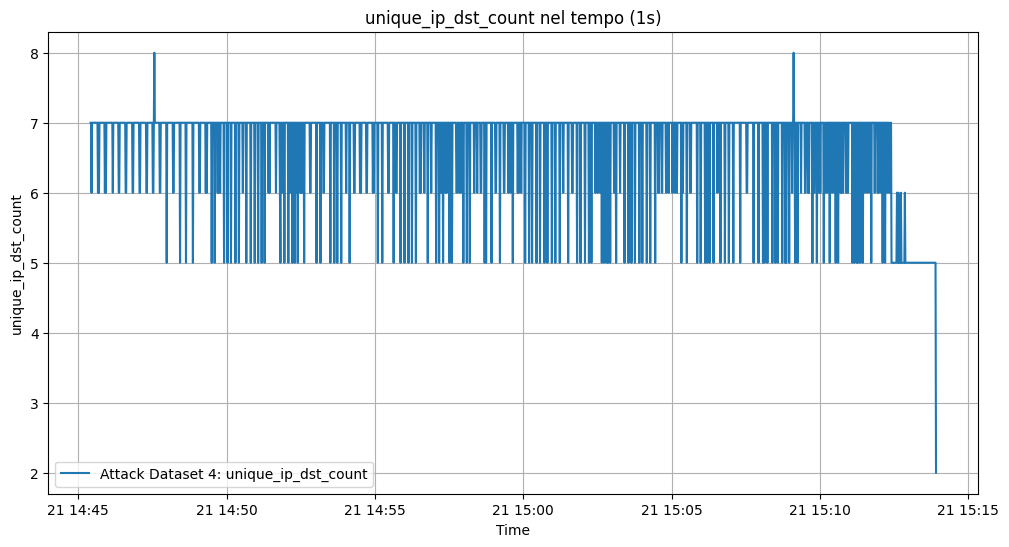

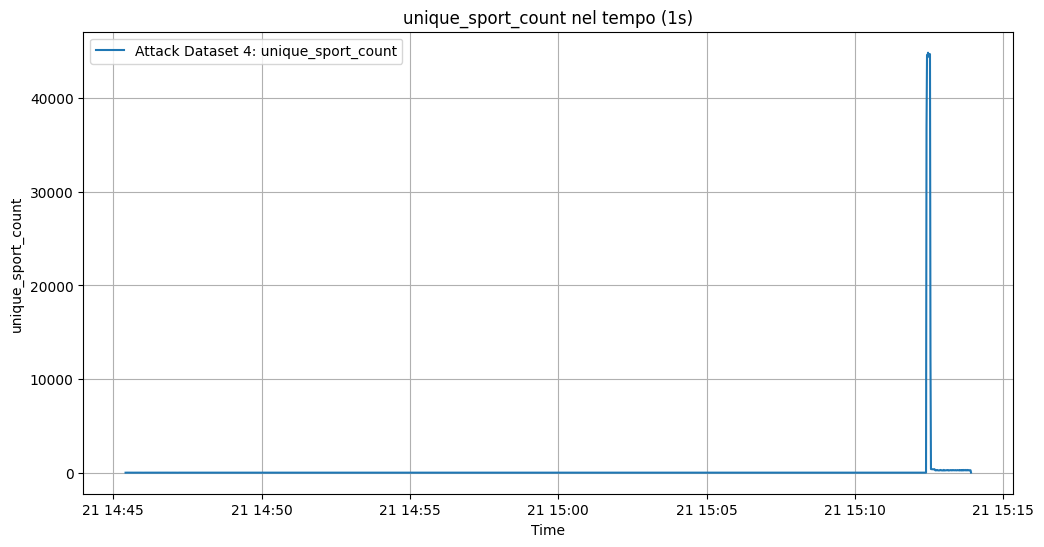

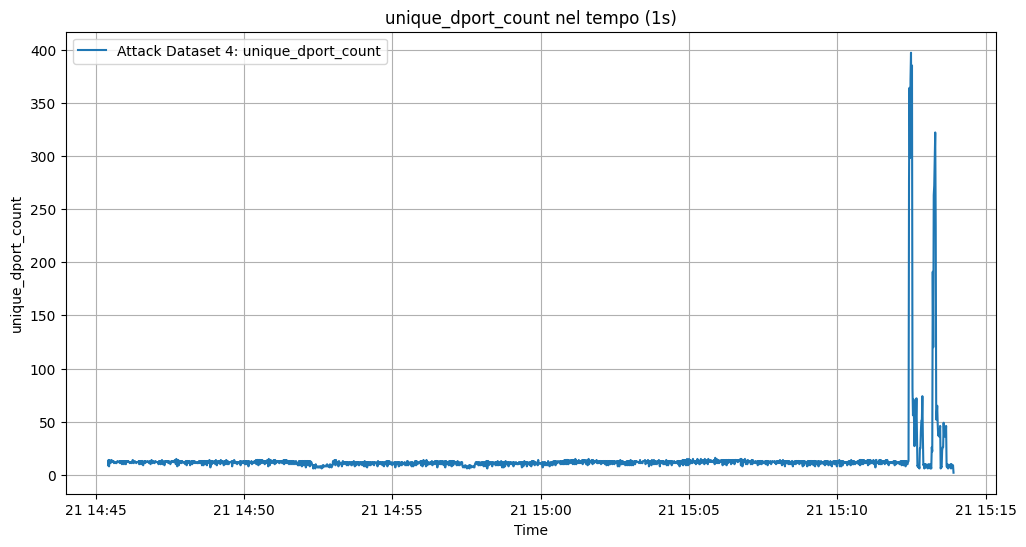

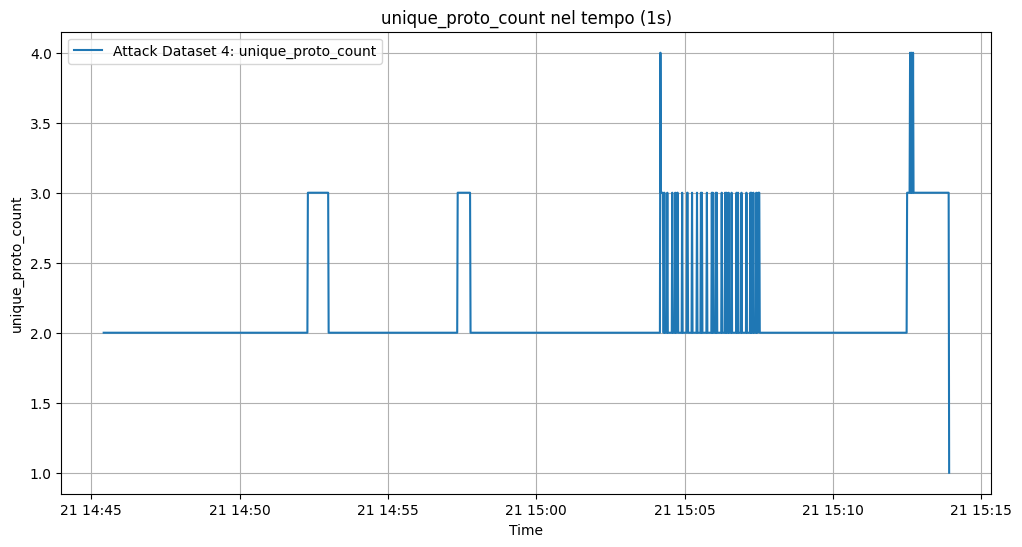

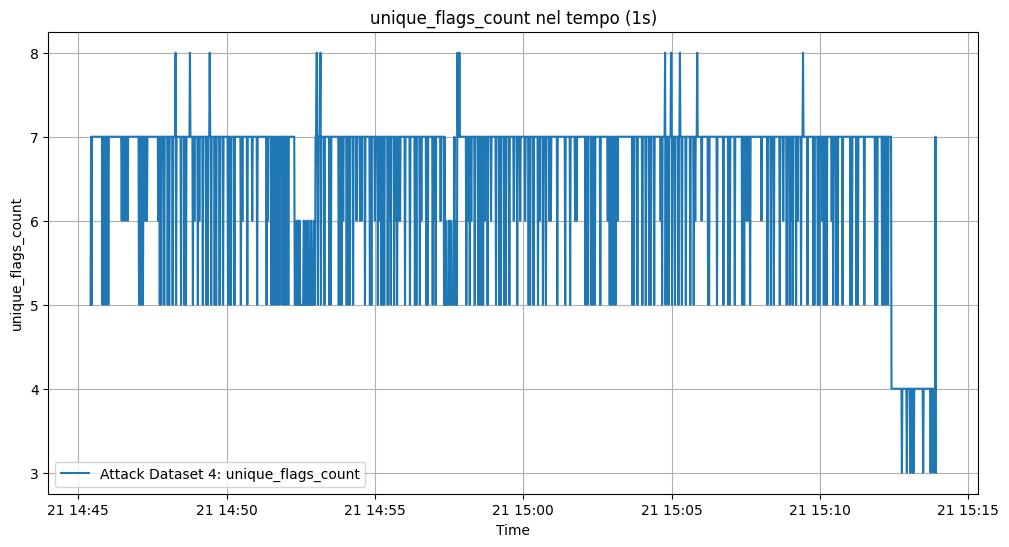

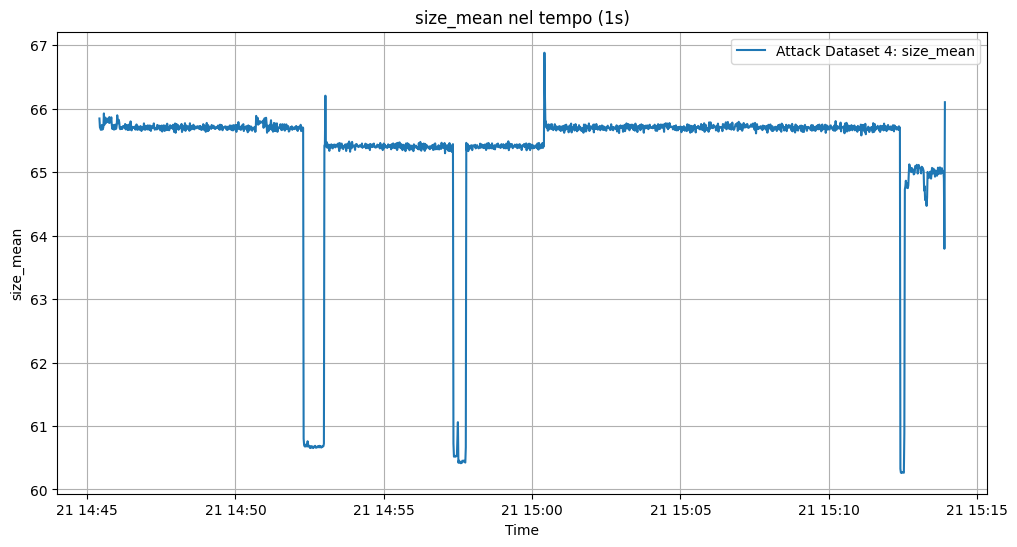

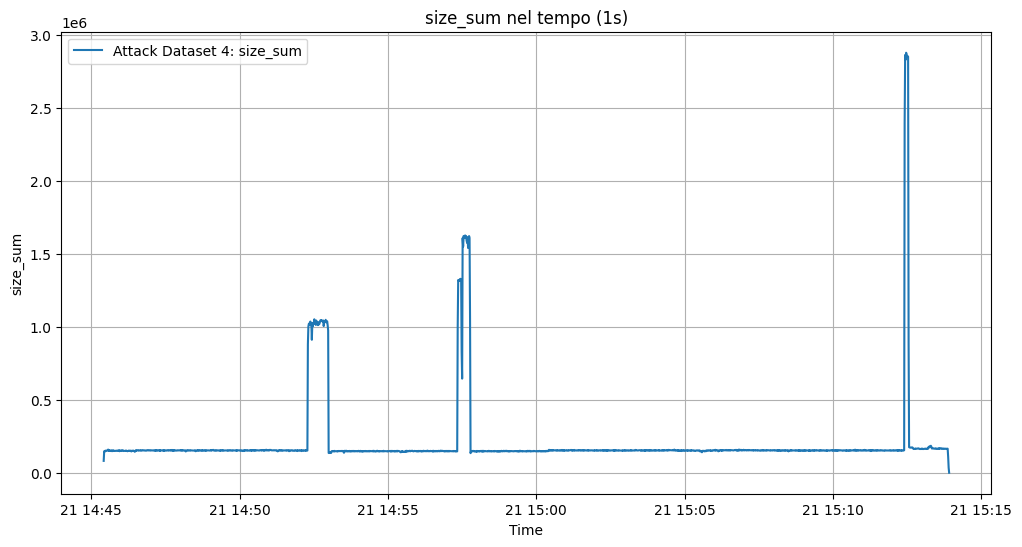

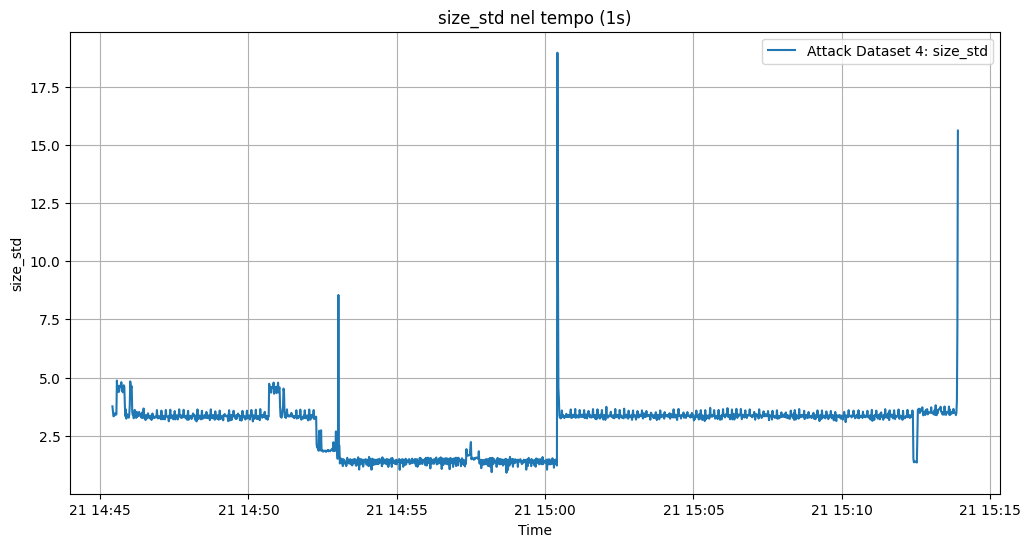

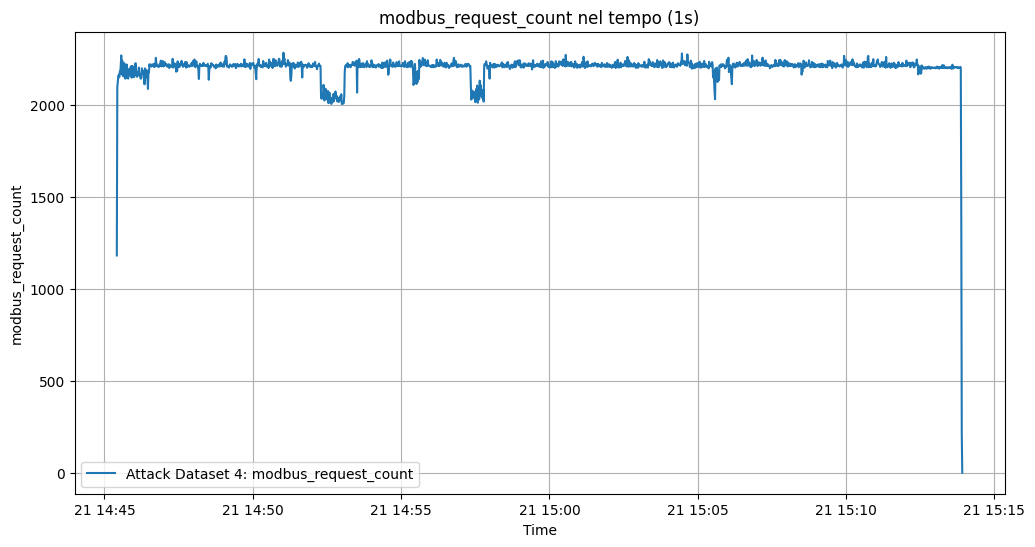

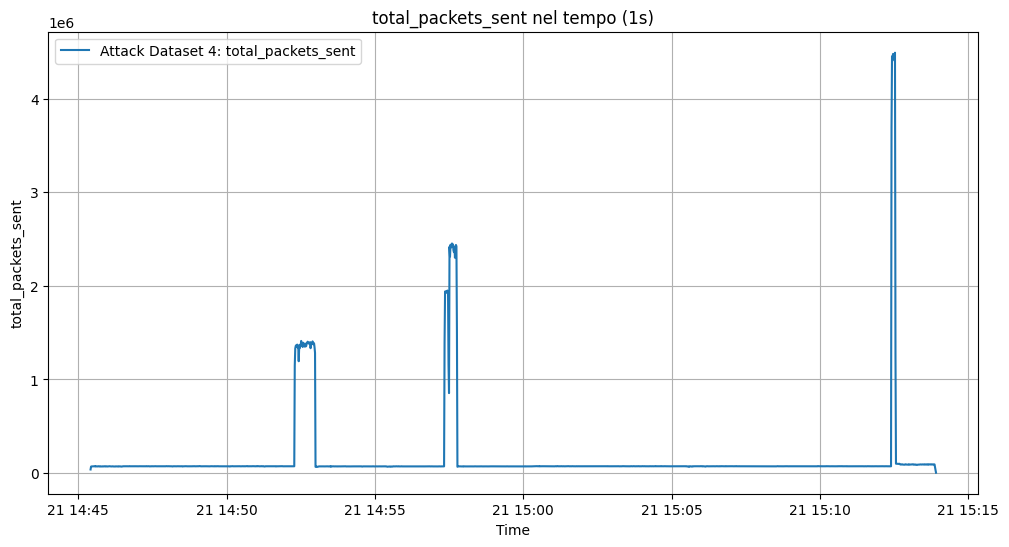

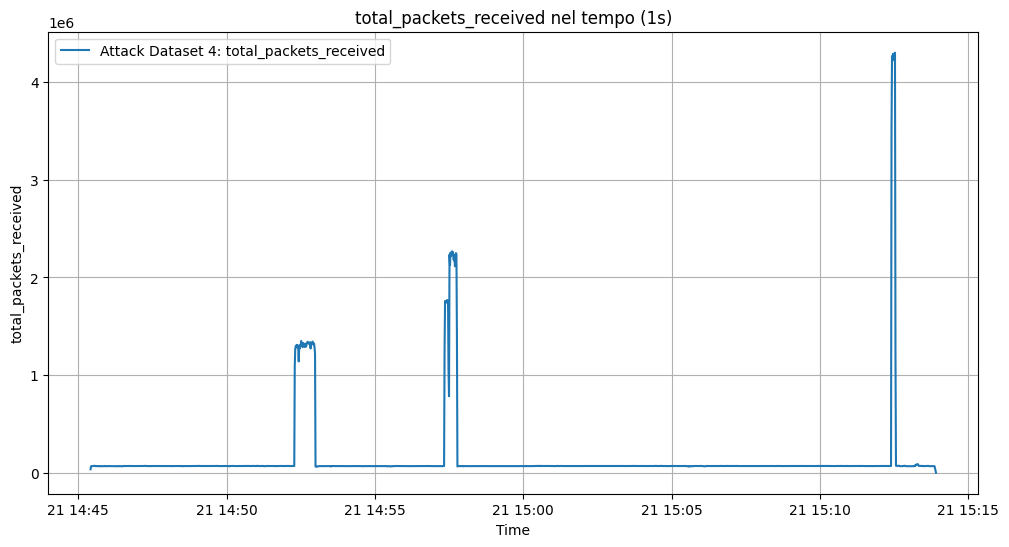

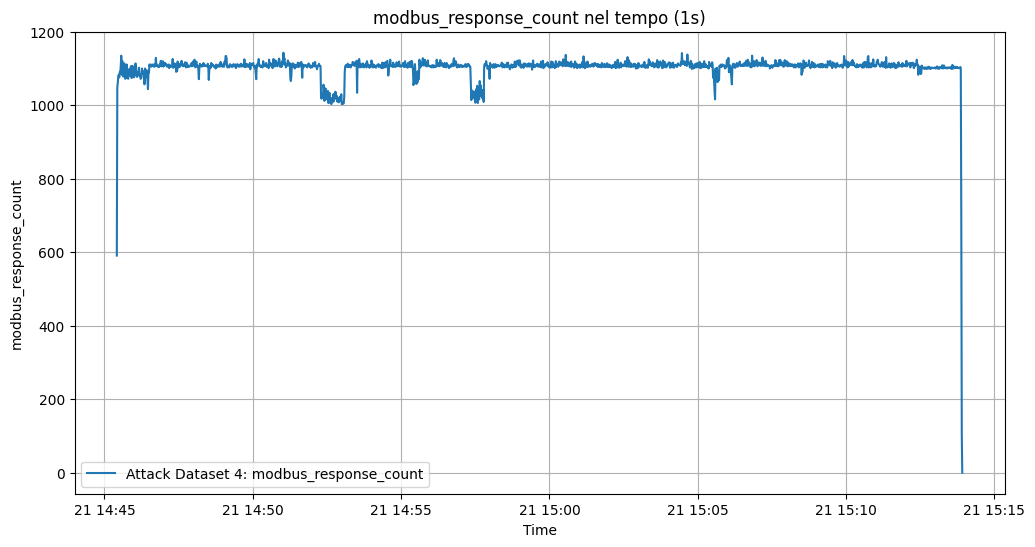

Preprocessing completato per i dataset di attacco.


In [8]:
# Dataset di attacco
attack_files = [  # Sostituisci con i file selezionati
    os.path.join(network_selected_folder, 'attack_1.csv'),
    os.path.join(network_selected_folder, 'attack_2.csv'),
    os.path.join(network_selected_folder, 'attack_3.csv'),
    os.path.join(network_selected_folder, 'attack_4.csv')
]

# Preprocessa ogni dataset di attacco
for idx, file_path in enumerate(attack_files, start=1):
    attack_output = os.path.join(network_selected_folder, f'processed_attack_{idx}_resampled.csv')
    preprocess_and_resample(
        file_path=file_path,
        output_path=attack_output,
        time_column='Time',
        resample_interval='1s',
        plot_data=True,
        label=f"Attack Dataset {idx}"
    )

print("Preprocessing completato per i dataset di attacco.")

## Preprocessing Physical Dataset

In questa sezione viene effettuato il preprocessing per il dataset relativo al processo fisico.

### Setup

In [9]:
import pandas as pd

### Caricamento del dataset fisico

Carichiamo il dataset importandolo da Google Drive.

Per fare ciò, è necessario importare preventivamente il dataset di dati fisici sul drive e selezionarlo fra le cartelle che compaiono quando si avvia il codice.

In [10]:
from google.colab import drive
import os
import ipywidgets as widgets
from IPython.display import display

# Monta Google Drive
drive.mount('/content/drive')

# Percorso di Google Drive
root_path = '/content/drive/My Drive/'

# Elenca le cartelle disponibili nella radice
folders = [name for name in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, name))]

# Crea un menu a tendina per selezionare una cartella per i file fisici
physical_folder_dropdown = widgets.Dropdown(
    options=folders,
    description='Fisico Folder:',
    disabled=False,
)

# Variabile globale per salvare la cartella selezionata per i file fisici
physical_selected_folder = None

# Funzione per aggiornare la cartella fisica selezionata
def on_physical_folder_selection(change):
    global physical_selected_folder
    physical_selected_folder = os.path.join(root_path, change['new'])
    print(f"Hai selezionato la cartella fisica: {physical_selected_folder}")

    # Elenca i file nella cartella selezionata
    file_list = [file for file in os.listdir(physical_selected_folder) if os.path.isfile(os.path.join(physical_selected_folder, file))]

    if file_list:
        # Mostra i file disponibili nella cartella selezionata
        print("File disponibili nella cartella selezionata (Fisico):")
        print(file_list)
    else:
        print("La cartella selezionata (Fisico) non contiene file.")

# Mostra il menu a tendina per la cartella fisica
display(physical_folder_dropdown)

# Assegna la funzione all'evento di selezione della cartella
physical_folder_dropdown.observe(on_physical_folder_selection, names='value')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dropdown(description='Fisico Folder:', options=('Isi', 'Benvenuto', 'Modelli e metodi', 'Programmazione', 'Not…

Hai selezionato la cartella fisica: /content/drive/My Drive/Physical Dataset
File disponibili nella cartella selezionata (Fisico):
['phy_att_4.csv', 'phy_att_2.csv', 'phy_att_1.csv', 'phy_norm.csv', 'phy_att_3.csv', 'processed_physical_normal_resampled.csv', 'processed_physical_attack_1_resampled.csv', 'processed_physical_attack_2_resampled.csv', 'processed_physical_attack_3_resampled.csv', 'processed_physical_attack_4_resampled.csv']


### Creazione funzione di preprocessing

Creiamo la funzione per effettuare il preprocessing del dataset dei dati del processo fisico.

La funzione `preprocess_physical_data` carica un dataset fisico, converte la colonna temporale in formato datetime, rimuove eventuali colonne non necessarie come `Label`, e salva il dataset preprocessato in un nuovo file CSV.

In [11]:
import pandas as pd

def preprocess_physical_data(file_path, output_path, time_column='Time', delimiter='\t', encoding='utf-16'):
    """
    Preprocessa il dataset fisico: converte la colonna temporale in datetime.

    Parameters:
    - file_path (str): Percorso al file CSV da preprocessare.
    - output_path (str): Percorso dove salvare il file preprocessato.
    - time_column (str): Nome della colonna temporale.
    - delimiter (str): Delimitatore del file CSV (di default '\t' per tab).
    - encoding (str): Codifica del file CSV (di default 'utf-16').
    """
    # Carica il dataset fisico con la codifica e delimitatore corretti
    df = pd.read_csv(file_path, sep=delimiter, encoding=encoding)
    df.columns = df.columns.str.strip()  # Rimuove spazi extra dai nomi delle colonne

    # Controlla se la colonna temporale esiste
    if time_column not in df.columns:
        raise ValueError(f"La colonna temporale '{time_column}' non è presente nel dataset.")

    # Converte la colonna temporale in datetime (specificando dayfirst=True per il formato giorno/mese/anno)
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce', dayfirst=True)

    # Rimuove solo la colonna `Label` (mantiene `label_n`)
    df.drop(columns=['Label'], inplace=True, errors='ignore')

    # Salva il dataset preprocessato
    df.to_csv(output_path, index=False)
    print(f"Dataset fisico preprocessato salvato in: {output_path}")

    return df

### Esecuzione del preprocessing

Eseguiamo il preprocessing per il file "phy_norm.csv". Questo file contiene solo dati relativi al processo fisico in condizioni di normalità.

In [12]:
# Dataset normale fisico
normal_physical_file = os.path.join(physical_selected_folder, 'phy_norm.csv')  # Percorso del file normale
normal_physical_output = os.path.join(physical_selected_folder, 'processed_physical_normal_resampled.csv')  # Percorso di output

# Preprocessa il dataset normale fisico
normal_physical_resampled = preprocess_physical_data(
    file_path=normal_physical_file,
    output_path=normal_physical_output,
    time_column='Time',
    delimiter='\t',  # Usando il tab come delimitatore per 'phy_norm.csv'
    encoding='utf-16'  # Codifica per 'phy_norm.csv'
)

Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_normal_resampled.csv


Esecuzione del preprocessing per i file contenenti i dati di attacco nel dataset fisico: "phy_attack_1.csv", "phy_attack_2.csv", "phy_attack_3.csv", "phy_attack_4.csv".

In [13]:
# Dataset di attacco fisico
attack_physical_files = [
    ('phy_att_1.csv', '\t', 'utf-16'),
    ('phy_att_2.csv', '\t', 'utf-16'),
    ('phy_att_3.csv', '\t', 'utf-16'),
    ('phy_att_4.csv', ',', 'utf-8-sig')
]

# Preprocessing per ogni file di attacco fisico
for idx, (file_name, delimiter, encoding) in enumerate(attack_physical_files, start=1):
    attack_physical_file = os.path.join(physical_selected_folder, file_name)  # Percorso del file
    attack_physical_output = os.path.join(physical_selected_folder, f'processed_physical_attack_{idx}_resampled.csv')  # Percorso di output

    preprocess_physical_data(
        file_path=attack_physical_file,
        output_path=attack_physical_output,
        time_column='Time',
        delimiter=delimiter,
        encoding=encoding
    )

Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_1_resampled.csv
Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_2_resampled.csv
Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_3_resampled.csv
Dataset fisico preprocessato salvato in: /content/drive/My Drive/Physical Dataset/processed_physical_attack_4_resampled.csv


## Unione di Network Dataset e Physical Dataset

Accorpiamo i file dei due dataset: Physical Dataset e Network Dataset.

L'obiettivo è quello di creare un file per effettuare l'addestramento dell'autoencoder che contenga solo la sequenza di dati etichettati come normali (label = 0), e un file di testing che contenga le sequenze che presentano anomalie (label = 1).

Per creare il dataset di training vengono accorpati i file **phy_norm.csv** e **normal.csv**.

Per creare il dataset di testing vengono accorpati i **file attack_1.csv**, **attack_2.csv**, **attack_3.csv**, **attack_4.csv** con **phy_att_1.csv**, **phy_att_2.csv**, **phy_att_3.csv**, **phy_att_4.csv**.
        
I file corrispondenti ad ogni attacco vengono accorpati in modo sincronizzato: ad ogni timestamp vengono fatte corrispondere tutte le feature appartenenti al dataset di network e al dataset fisico. In seguito, tutti i 4 file accoppiati vengono uniti in un unico dataset.
Inoltre, anche le label vengono accorpate secondo la seguente regola:
- Se almeno uno dei due dati dello stesso timestamp ha label=1, al dato viene associata label=1.
- Se entrambi i dati del timestamp hanno label=0, al dato viene associata la label=0.

### Setup

Importa le librerie necessarie, configura l'ambiente e crea le cartelle di output.

In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, Conv1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Impostazioni di visualizzazione per pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Verifica della versione di TensorFlow
print(f"Versione di TensorFlow: {tf.__version__}")

# Creazione della cartella combined_data
output_dir = '/content/combined_data'
os.makedirs(output_dir, exist_ok=True)
print(f"Cartella combinata creata o già esistente: {output_dir}")

Versione di TensorFlow: 2.17.1
Cartella combinata creata o già esistente: /content/combined_data


### Preprocessing e combinazione dataset

La funzione `preprocess_dataset` carica e unisce più file CSV, standardizza i nomi delle colonne, corregge eventuali variazioni nel nome `label_n`, e gestisce i valori mancanti per la colonna `label_n` nei dataset di test.

In [15]:
def preprocess_dataset(file_paths, is_test=False):
    combined_data = pd.DataFrame()
    for file_path in file_paths:
        print(f"Caricando il file: {file_path}")
        data = pd.read_csv(file_path)
        data.columns = data.columns.str.strip().str.lower()
        data.columns = data.columns.str.replace('lable_n', 'label_n', regex=False) \
            .str.replace('labl_n', 'label_n', regex=False) \
            .str.replace('lable', 'label', regex=False)
        if is_test:
            if 'label_n' in data.columns:
                data['label_n'] = data['label_n'].fillna(0)
            else:
                data['label_n'] = 0
        combined_data = pd.concat([combined_data, data], ignore_index=True)
    return combined_data

La funzione `combine_datasets` unisce i dataset di rete e fisici basandosi sul timestamp, assegna una nuova etichetta binaria `label` combinando i valori delle etichette originali, e restituisce il dataset combinato.

In [16]:
def combine_datasets(network_data, physical_data):
    network_data['time'] = pd.to_datetime(network_data['time'], errors='coerce')
    physical_data['time'] = pd.to_datetime(physical_data['time'], errors='coerce')
    network_data.set_index('time', inplace=True)
    physical_data.set_index('time', inplace=True)
    combined_data = network_data.join(physical_data, how='inner', lsuffix='_net', rsuffix='_phy')
    combined_data['label'] = np.where(
        (combined_data.get('label_n_net', 0) == 0) & (combined_data.get('label_n_phy', 0) == 0),
        0,
        1
    )
    combined_data.drop(columns=['label_n_net', 'label_n_phy'], inplace=True, errors='ignore')
    combined_data.reset_index(inplace=True)
    return combined_data

### Divisione in training e test

Effettuiamo il preprocessing dei file di training: utilizziamo il dataset fisico e il dataset di rete contenenti solo dati etichettati come normali e li combiniamo insieme per creare il file di training.

In [17]:
train_network_files = [
    os.path.join(network_selected_folder, 'processed_normal_resampled.csv')  # File preprocessato
]

train_physical_files = [
    os.path.join(physical_selected_folder, 'processed_physical_normal_resampled.csv')  # File preprocessato
]

# Preprocessing dei dati di training
print("Preprocessing dei dati normali di training...")
train_network_data = preprocess_dataset(train_network_files)
train_physical_data = preprocess_dataset(train_physical_files)
train_combined_data = combine_datasets(train_network_data, train_physical_data)

# Salvo i dati di training con la colonna time in una nuova variabile
train_with_time = train_combined_data
print("Colonne di train_with_time:", train_with_time.columns.tolist())



Preprocessing dei dati normali di training...
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_normal_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_normal_resampled.csv
Colonne di train_with_time: ['time', 'unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'total_packets_received', 'modbus_response_count', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12', 'valv_13', 'valv_14', 'valv_15', 'valv_16', 'va

Effettuiamo il preprocessing dei file di test: utilizziamo il dataset fisico e il dataset di rete contenenti anche dati etichettati come anomali e li combiniamo insieme per creare il file di testing.

In [18]:
# File di test con dati di attacco
test_network_files = [
    os.path.join(network_selected_folder, 'processed_attack_1_resampled.csv'),
    os.path.join(network_selected_folder, 'processed_attack_2_resampled.csv'),
    os.path.join(network_selected_folder, 'processed_attack_3_resampled.csv'),
    os.path.join(network_selected_folder, 'processed_attack_4_resampled.csv')
]

test_physical_files = [
    os.path.join(physical_selected_folder, 'processed_physical_attack_1_resampled.csv'),
    os.path.join(physical_selected_folder, 'processed_physical_attack_2_resampled.csv'),
    os.path.join(physical_selected_folder, 'processed_physical_attack_3_resampled.csv'),
    os.path.join(physical_selected_folder, 'processed_physical_attack_4_resampled.csv')
]

# Preprocessing dei dati di test
print("Preprocessing dei dati di attacco di test...")
test_network_data = preprocess_dataset(test_network_files, is_test=True)
test_physical_data = preprocess_dataset(test_physical_files, is_test=True)
test_combined_data = combine_datasets(test_network_data, test_physical_data)

# Preprocessing dei dati di test
print("Preprocessing dei dati di attacco di test...")

# Preprocessing dei dati di rete
test_network_data = preprocess_dataset(test_network_files, is_test=True)
print("\nFeature del dataset di rete di test (prime 5 righe):")
print(test_network_data.head())

# Preprocessing dei dati fisici
test_physical_data = preprocess_dataset(test_physical_files, is_test=True)
print("\nFeature del dataset fisico di test (prime 5 righe):")
print(test_physical_data.head())

# Combinazione dei dati di rete e fisici
test_combined_data = combine_datasets(test_network_data, test_physical_data)
print("\nFeature del dataset combinato di test (prime 5 righe):")
print(test_combined_data.head())

# Salvo i dati di test con la colonna time in una nuova variabile
test_with_time = test_combined_data

Preprocessing dei dati di attacco di test...
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_1_resampled.csv
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_2_resampled.csv
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_3_resampled.csv
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_4_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_1_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_2_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_3_resampled.csv
Caricando il file: /content/drive/My Drive/Physical Dataset/processed_physical_attack_4_resampled.csv
Preprocessing dei dati di attacco di test...
Caricando il file: /content/drive/My Drive/NetworkDataset/processed_attack_1_resampled.csv
Caricando il file: /content/drive/My Drive/Netw

### Feature Selection

Effettuiamo la selezione delle feature più rilevanti.

Il codice di seguito analizza il dataset combinato di test visualizzando la matrice di correlazione, identificando le feature più importanti basate sulla varianza, e individuando coppie di feature altamente correlate.


Analisi del dataset combinato di test...
Feature attualmente nel dataset combinato di test:
['time', 'unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'total_packets_received', 'modbus_response_count', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12', 'valv_13', 'valv_14', 'valv_15', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']


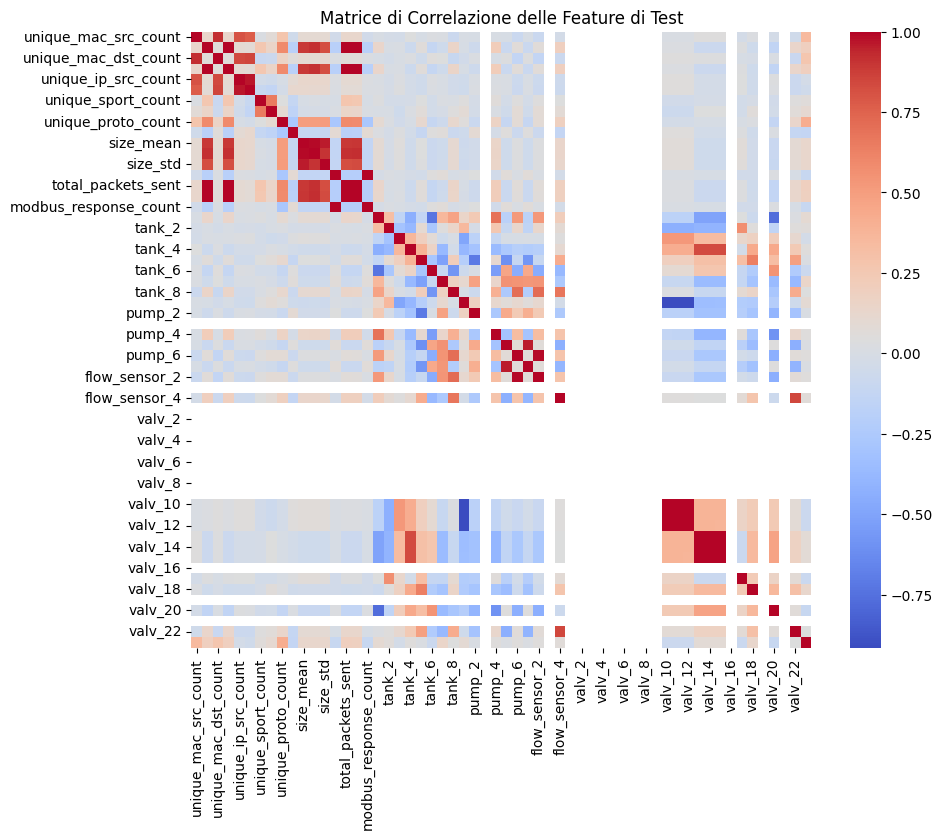

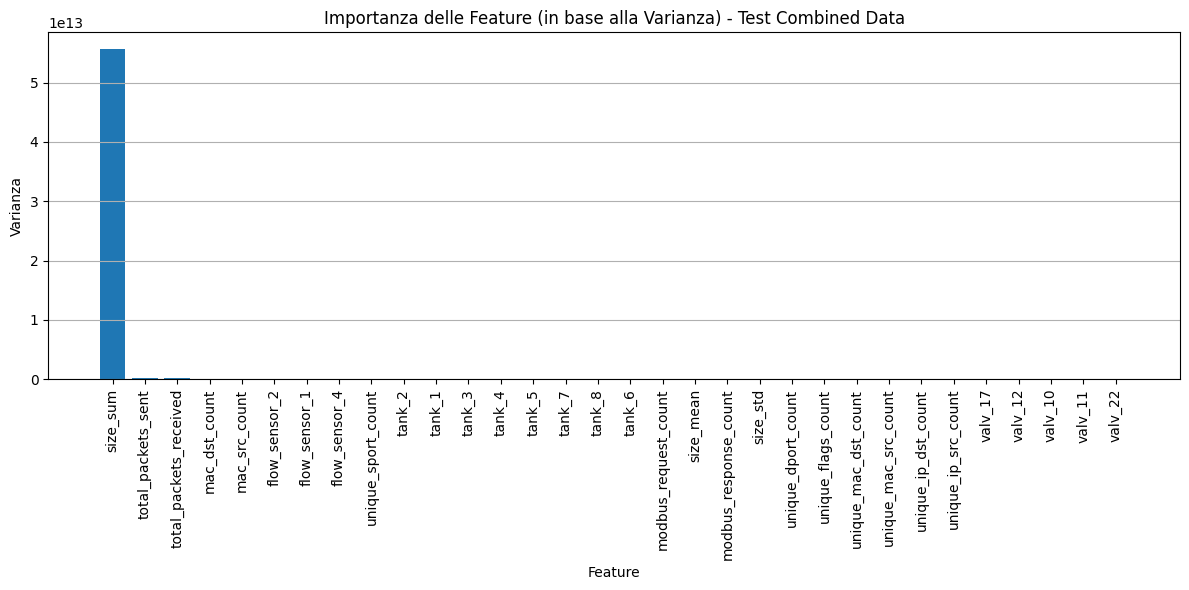

Feature altamente correlate (correlazione > 0.9):
unique_mac_src_count - unique_mac_dst_count: 0.92
mac_src_count - mac_dst_count: 1.00
mac_src_count - size_sum: 0.91
mac_src_count - total_packets_sent: 1.00
mac_src_count - total_packets_received: 1.00
unique_mac_dst_count - unique_mac_src_count: 0.92
mac_dst_count - mac_src_count: 1.00
mac_dst_count - size_sum: 0.91
mac_dst_count - total_packets_sent: 1.00
mac_dst_count - total_packets_received: 1.00
unique_ip_src_count - unique_ip_dst_count: 0.96
unique_ip_dst_count - unique_ip_src_count: 0.96
size_mean - size_sum: 0.99
size_mean - size_std: 0.96
size_mean - total_packets_received: 0.90
size_sum - mac_src_count: 0.91
size_sum - mac_dst_count: 0.91
size_sum - size_mean: 0.99
size_sum - size_std: 0.91
size_sum - total_packets_sent: 0.91
size_sum - total_packets_received: 0.92
size_std - size_mean: 0.96
size_std - size_sum: 0.91
modbus_request_count - modbus_response_count: 1.00
total_packets_sent - mac_src_count: 1.00
total_packets_sen

In [19]:
# Visualizzazione della matrice di correlazione e importanza delle feature
print("\nAnalisi del dataset combinato di test...")

print("Feature attualmente nel dataset combinato di test:")
print(test_combined_data.columns.tolist())

# Matrice di correlazione
plt.figure(figsize=(10, 8))
correlation_matrix = test_combined_data.corr(numeric_only=True)  # Considera solo colonne numeriche
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Matrice di Correlazione delle Feature di Test')
plt.show()

# Importanza delle feature basata sulla varianza
feature_variances = test_combined_data.var(numeric_only=True).sort_values(ascending=False)

# Plot delle feature più importanti
num_features_to_plot = min(32, len(feature_variances))
top_features = feature_variances.index[:num_features_to_plot]
top_importances = feature_variances.values[:num_features_to_plot]

plt.figure(figsize=(12, 6))
plt.bar(range(num_features_to_plot), top_importances, align='center')
plt.xticks(range(num_features_to_plot), top_features, rotation=90)
plt.title('Importanza delle Feature (in base alla Varianza) - Test Combined Data')
plt.xlabel('Feature')
plt.ylabel('Varianza')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Definisci un insieme di feature protette che non devono mai essere rimosse
protected_features = {'size_sum'}

# Soglia per considerare due feature come altamente correlate
correlation_threshold = 0.9

# Calcola la matrice di correlazione
correlation_matrix = test_combined_data.corr(numeric_only=True)

# Trova le coppie di feature con correlazione sopra la soglia
high_correlation_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > correlation_threshold
]

# Stampa le coppie di feature altamente correlate
print("Feature altamente correlate (correlazione > 0.9):")
for col1, col2, corr_value in high_correlation_pairs:
    print(f"{col1} - {col2}: {corr_value:.2f}")

Visualizziamo la varianza delle feature rimanenti.

Colonne train: ['time', 'unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'total_packets_received', 'modbus_response_count', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12', 'valv_13', 'valv_14', 'valv_15', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']
Colonne test: ['time', 'unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'un

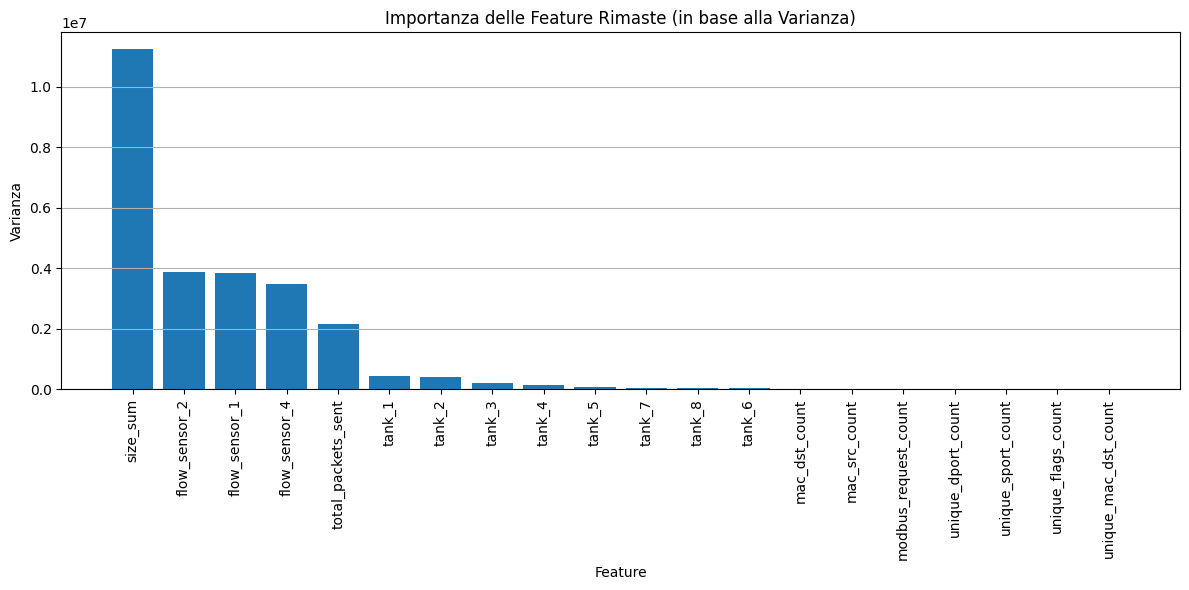

Colonne train: ['time', 'unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_13', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']
Colonne test: ['time', 'unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_s

In [20]:
print("Colonne train:", train_combined_data.columns.tolist())
print("Colonne test:", test_combined_data.columns.tolist())

# Elimino una delle feature fra le coppie con correlazione univoca (=1)
features_to_remove = ['modbus_response_count', 'total_packets_received',
'valv_11', 'valv_12', 'valv_14', 'valv_15'
]

train_combined_data.drop(columns=features_to_remove, errors='ignore', inplace=True)
test_combined_data.drop(columns=features_to_remove, errors='ignore', inplace=True)

# Separazione delle feature
features = list(set(train_combined_data.columns) - {'label'})
features.sort()

print("Feature attualmente presenti nel dataset combinato di train:")
print(train_combined_data.columns.tolist())


# Importanza delle feature rimaste basata sulla varianza
remaining_feature_variances = train_combined_data[features].var(numeric_only=True).sort_values(ascending=False)

# Stampa l'importanza delle feature rimaste
print("\nImportanza delle feature rimaste (basata sulla varianza):")
print(remaining_feature_variances)

# Plot delle feature rimaste ordinate per importanza
num_features_to_plot = min(20, len(remaining_feature_variances))
top_remaining_features = remaining_feature_variances.index[:num_features_to_plot]
top_remaining_importances = remaining_feature_variances.values[:num_features_to_plot]

plt.figure(figsize=(12, 6))
plt.bar(range(num_features_to_plot), top_remaining_importances, align='center')
plt.xticks(range(num_features_to_plot), top_remaining_features, rotation=90)
plt.title('Importanza delle Feature Rimaste (in base alla Varianza)')
plt.xlabel('Feature')
plt.ylabel('Varianza')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

print("Colonne train:", train_combined_data.columns.tolist())
print("Colonne test:", test_combined_data.columns.tolist())


Eliminiamo le feature con bassa varianza.

### Data Cleaning e Normalizzazione

In [21]:
# Rimozione di colonne di tipo datetime
datetime_cols = train_combined_data.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
train_combined_data.drop(columns=datetime_cols, inplace=True, errors='ignore')
test_combined_data.drop(columns=datetime_cols, inplace=True, errors='ignore')

# Separazione delle feature e normalizzazione
features = list(set(train_combined_data.columns) - {'label'})
features.sort()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_combined_data[features].values)
X_test = scaler.transform(test_combined_data[features].values)

# Separazione del target
y_train = train_combined_data['label'].values
y_test = test_combined_data['label'].values

print("Colonne di train_with_time:", train_with_time.columns.tolist())
print("Colonne di test_with_time:", test_with_time.columns.tolist())


Colonne di train_with_time: ['unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_13', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']
Colonne di test_with_time: ['unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum

### Creazione di sequenze temporali

Creiamo sequenze temporali di lunghezza definita dai dati di training normali e dai dati di test, mantenendo etichette costanti per sequenza (con solo etichetta "normal").

In [64]:
def create_sequences(data, labels, seq_length=95):
    sequences = []
    seq_labels = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i + seq_length]
        label_seq = labels[i:i + seq_length]
        if np.all(label_seq == label_seq[0]):
            sequences.append(seq)
            seq_labels.append(label_seq[0])
    return np.array(sequences), np.array(seq_labels)

# Creazione delle sequenze per il training (solo normali)
sequence_length = 150
normal_indices = np.where(y_train == 0)[0]
X_train_normal = X_train[normal_indices]
y_train_normal = y_train[normal_indices]
X_train_seq, y_train_seq = create_sequences(X_train_normal, y_train_normal, sequence_length)

# Creazione delle sequenze per il test
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Anomaly Detection

## Addestramento del VAE

Per effettuare il task di Anomaly Detection per Time Series utilizziamo un **VAE (Variational Autoencoder)**: è un modello generativo che apprende rappresentazioni probabilistiche dei dati in uno spazio latente, combinando un encoder (che mappa i dati nello spazio latente) e un decoder (che ricostruisce i dati dagli embedding latenti).

In **Anomaly Detection per Time Series**, il VAE viene addestrato su sequenze normali, imparando a ricostruire fedelmente questi dati. Durante il test, le anomalie generano errori di ricostruzione elevati poiché i dati anomali non seguono il modello appreso.

### Definizione del VAE

Definiamo la classe VAE, le funzioni di sampling e i costruttori per l'encoder e il decoder.

In [65]:
# Definizione della funzione di campionamento
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Definizione della classe VAE
class VAE(Model):
    def __init__(self, encoder, decoder, alpha=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha  # Peso per la reconstruction loss
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed)) * inputs.shape[1] * inputs.shape[2]
        reconstruction_loss *= self.alpha

        # KL divergence
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5

        # Total loss
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return reconstructed

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

### Costruzione di Encoder-Decoder

Definiamo le funzioni per creare l'encoder e il decoder.

In [66]:
from tensorflow.keras.regularizers import l2

# Funzione per costruire l'encoder
def build_encoder(sequence_length, num_features, latent_dim=5):
    encoder_inputs = Input(shape=(sequence_length, num_features), name='encoder_input')
    x = Conv1D(8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(encoder_inputs)
    x = BatchNormalization()(x)
    x = LSTM(32, activation='tanh', return_sequences=False, kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.55)(x)
    z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=l2(1e-3))(x)
    z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=l2(1e-3))(x)
    return Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

# Funzione per costruire il decoder
def build_decoder(sequence_length, num_features, latent_dim=5):
    decoder_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = RepeatVector(sequence_length)(decoder_inputs)
    x = LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.55)(x)
    x = Conv1D(8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-3))(x)
    decoder_outputs = Conv1D(num_features, kernel_size=3, activation='linear', padding='same', kernel_regularizer=l2(1e-3))(x)
    return Model(decoder_inputs, decoder_outputs, name='decoder')

### Costruzione del VAE

Creiamo l'encoder, il decoder e costruiamo il modello VAE.

In [67]:
# Parametri del modello
latent_dim = 5
num_features = X_train_seq.shape[2]

# Costruzione dell'encoder e del decoder
encoder = build_encoder(sequence_length, num_features, latent_dim)
decoder = build_decoder(sequence_length, num_features, latent_dim)

# Costruzione e compilazione del VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
vae.summary()

Model: "vae_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ [(None, 5), (None, 5)]      │           6,842 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 150, 51)             │           6,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,757 (53.74 KB)

 Trainable params: 13,741 (53.68 KB)

 Non-trainable params: 16 (64.00 B)

### Addestramento del VAE

Addestriamo il VAE sui dati normali.

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - kl_loss: 0.2050 - reconstruction_loss: 3019.7195 - total_loss: 3019.9246 - val_kl_loss: 0.2058 - val_reconstruction_loss: 2924.8230 - val_total_loss: 2925.0291
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,reconstruction_loss,total_loss,val_kl_loss,val_reconstruction_loss,val_total_loss
  current = self.get_monitor_value(logs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - kl_loss: 0.3244 - reconstruction_loss: 2878.2588 - total_loss: 2878.5835 - val_kl_loss: 0.5571 - val_reconstruction_loss: 2767.5088 - val_total_loss: 2768.0657
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - kl_loss: 0.9649 - reconstruction_loss: 2667.8425 - total_loss: 2668.8071 - val_kl_loss: 2.2468 - val_reconstruction_loss: 2411.3186 - val_total_loss: 2413.5654
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - kl_loss: 2.9173 - reconstruction_loss: 2248.3884 - total_loss: 2251.3054 - val_kl_loss: 4.2166 - val_reconstruction_loss: 1892.3951 - val_total_loss: 1896.6118
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - kl_loss: 4.6697 - reconstruction_loss: 1729.8542 - total_loss: 1734.5242 - val_kl_loss: 5.4489 - val_reconstruction_loss: 1418.5133 - val_total_loss: 1423.9620
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - kl_loss: 5.7796 - reconstruction_loss: 1305.6564 - total_loss: 1311.4359 - val_kl_loss: 6.2227 

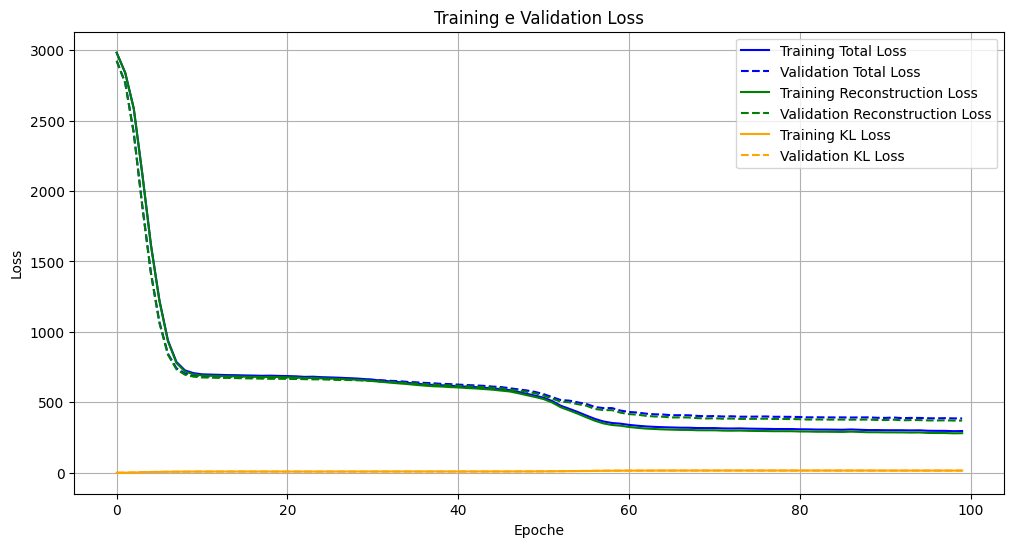

In [68]:
# Funzione per aggiungere rumore ai dati
def add_noise(data, noise_factor=0.01):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy_data, 0., 1.)

# Aggiunta di rumore ai dati di training
X_train_seq_noisy = add_noise(X_train_seq)

# Addestramento del modello
history = vae.fit(
    X_train_seq_noisy,
    X_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)

# Plot delle curve di perdita durante il training e la validation
plt.figure(figsize=(12, 6))

# Perdita totale
plt.plot(history.history['total_loss'], label='Training Total Loss', color='blue')
plt.plot(history.history['val_total_loss'], label='Validation Total Loss', color='blue', linestyle='--')

# Reconstruction Loss
plt.plot(history.history['reconstruction_loss'], label='Training Reconstruction Loss', color='green')
plt.plot(history.history['val_reconstruction_loss'], label='Validation Reconstruction Loss', color='green', linestyle='--')

# KL Divergence Loss
plt.plot(history.history['kl_loss'], label='Training KL Loss', color='orange')
plt.plot(history.history['val_kl_loss'], label='Validation KL Loss', color='orange', linestyle='--')

# Impostazioni del grafico
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Training e Validation Loss')
plt.legend()
plt.grid()
plt.show()

### Valutazione del VAE

Valutiamo il modello sul set di test.

In [69]:
# Predizioni sul training set
X_train_pred = vae.predict(X_train_seq)
train_mse = np.mean(np.power(X_train_seq - X_train_pred, 2), axis=(1, 2))

# Predizioni sul test set
X_test_pred = vae.predict(X_test_seq)
test_mse = np.mean(np.power(X_test_seq - X_test_pred, 2), axis=(1, 2))

# Calcolo della soglia ottimale utilizzando la curva Precision-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test_seq, test_mse)
ap = average_precision_score(y_test_seq, test_mse)
fscore = (2 * precision * recall) / (precision + recall + 1e-10)
ix = np.argmax(fscore)
optimal_threshold = thresholds_pr[ix]

print(f"Soglia ottimale (F1 Score massimo): {optimal_threshold}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Soglia ottimale (F1 Score massimo): 0.23564035412396758


### Visualizzazione dei risultati

Visualizziamo i risultati della valutazione del VAE sul test set.

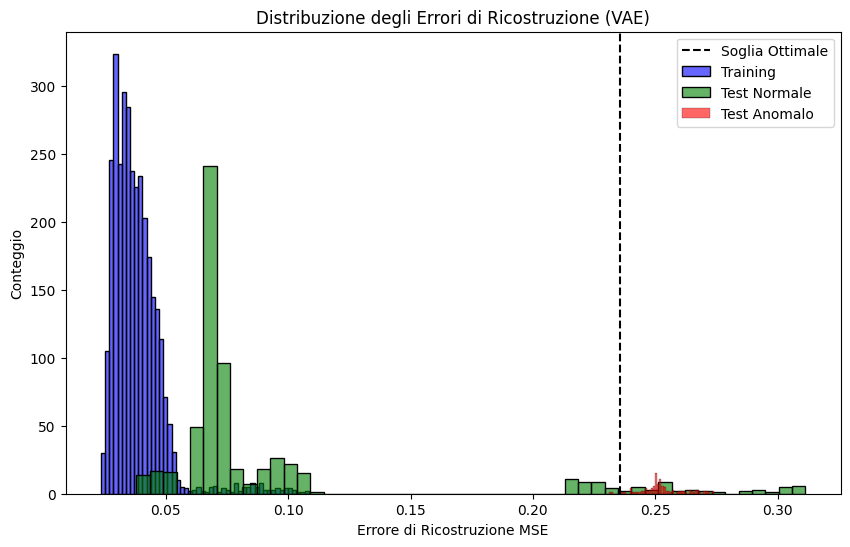

AUC Score: 0.950


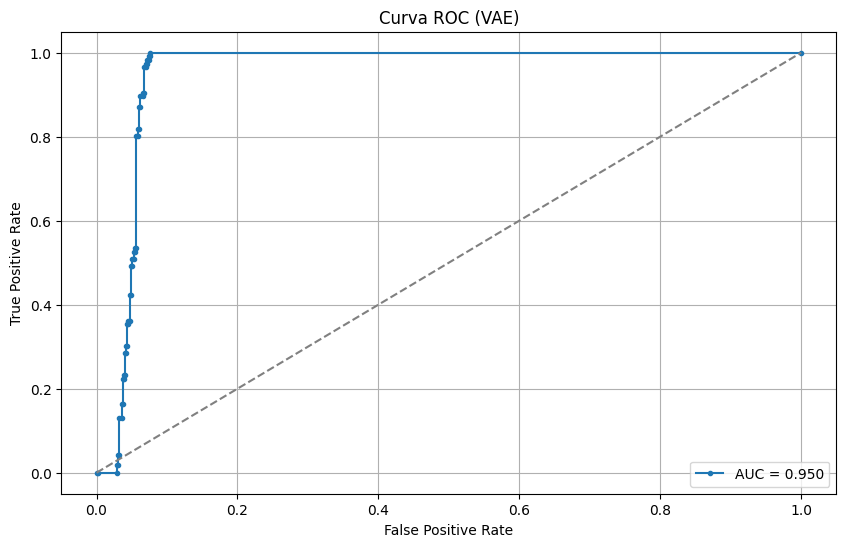


--- Valutazione con Soglia Ottimale (VAE) ---
              precision    recall  f1-score   support

     Normale       0.99      0.93      0.96       617
     Anomalo       0.72      0.97      0.83       116

    accuracy                           0.94       733
   macro avg       0.86      0.95      0.89       733
weighted avg       0.95      0.94      0.94       733



In [70]:
from sklearn.metrics import roc_auc_score, roc_curve

# Distribuzione degli errori di ricostruzione
plt.figure(figsize=(10, 6))
sns.histplot(train_mse, bins=50, color='blue', alpha=0.6, label='Training')
sns.histplot(test_mse[y_test_seq == 0], bins=50, color='green', alpha=0.6, label='Test Normale')
sns.histplot(test_mse[y_test_seq == 1], bins=50, color='red', alpha=0.6, label='Test Anomalo')
plt.axvline(optimal_threshold, color='black', linestyle='--', label='Soglia Ottimale')
plt.xlabel('Errore di Ricostruzione MSE')
plt.ylabel('Conteggio')
plt.title('Distribuzione degli Errori di Ricostruzione (VAE)')
plt.legend()
plt.show()

# Calcolo e stampa del valore AUC
auc_score = roc_auc_score(y_test_seq, test_mse)
print(f"AUC Score: {auc_score:.3f}")

# Plot della curva ROC
fpr, tpr, _ = roc_curve(y_test_seq, test_mse)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC (VAE)')
plt.legend()
plt.grid()
plt.show()

# Classificazione basata sulla soglia ottimale
y_pred_optimal = (test_mse > optimal_threshold).astype(int)

# Valutazione delle prestazioni
print("\n--- Valutazione con Soglia Ottimale (VAE) ---")
print(classification_report(y_test_seq, y_pred_optimal, target_names=['Normale', 'Anomalo']))

# Anomaly Prediction

## Addestramento LSTM

Per effettuare il task di Anomaly Prediction per Time Series utilizziamo una **LSTM (Long Short Term Memory)**: è una variante delle reti ricorrenti (RNN) progettata per catturare dipendenze a lungo termine nei dati sequenziali. Le LSTM sono particolarmente adatte per analizzare serie temporali grazie alla loro capacità di gestire informazioni a diverse scale temporali.

Nel contesto dell'Anomaly Detection, un modello LSTM viene addestrato su sequenze di dati normali per prevedere i valori successivi o ricostruire le sequenze stesse. Durante il test, se l'errore di previsione o ricostruzione è significativamente alto rispetto ai dati di training, il modello identifica la presenza di un'anomalia.

### Setup

In [26]:
# Importa le librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LSTM, RepeatVector

### Caricamento del dataset

Carichiamo nuovamente i dataset di training e di test dopo aver effettuato il preprocessing e ordinati nel tempo.

In [27]:
# Assicurati che le colonne 'time' siano in formato datetime
train_data = train_with_time
test_data = test_with_time
print("Colonne di train_with_time:", train_with_time.columns.tolist())
print("Colonne di test_with_time:", test_with_time.columns.tolist())

# Verifica che l'indice sia di tipo datetime
print("Tipo dell'indice di train_with_time:", train_with_time.index.dtype)
print("Tipo dell'indice di test_with_time:", test_with_time.index.dtype)

# Se l'indice non è di tipo datetime, convertilo
if not pd.api.types.is_datetime64_any_dtype(train_with_time.index):
    train_with_time.index = pd.to_datetime(train_with_time.index)
    print("Indice di train_with_time convertito in datetime.")

if not pd.api.types.is_datetime64_any_dtype(test_with_time.index):
    test_with_time.index = pd.to_datetime(test_with_time.index)
    print("Indice di test_with_time convertito in datetime.")

# Verifica che l'indice sia di tipo datetime
print("Tipo dell'indice di train_with_time:", train_with_time.index.dtype)
print("Tipo dell'indice di test_with_time:", test_with_time.index.dtype)

Colonne di train_with_time: ['unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum', 'size_std', 'modbus_request_count', 'total_packets_sent', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6', 'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5', 'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3', 'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5', 'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_13', 'valv_16', 'valv_17', 'valv_18', 'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label']
Colonne di test_with_time: ['unique_mac_src_count', 'mac_src_count', 'unique_mac_dst_count', 'mac_dst_count', 'unique_ip_src_count', 'unique_ip_dst_count', 'unique_sport_count', 'unique_dport_count', 'unique_proto_count', 'unique_flags_count', 'size_mean', 'size_sum

### Selezione delle feature e normalizzazione

Il codice di seguito normalizza le feature selezionate di training e test con Min-Max Scaling per garantire che i dati siano su una scala uniforme (0-1), necessario per migliorare la stabilità numerica e la convergenza dell'LSTM, che è sensibile a input non normalizzati.

In [29]:
# Seleziona la feature da modellare
features = ['size_sum', 'flow_sensor_2',
            'tank_2', 'tank_3']

# Indici delle feature target (tutte le feature in questo caso)
target_indices = [features.index('size_sum'), features.index('flow_sensor_2'),
                  features.index('tank_2'),  features.index('tank_3')]

# Prepara i dati di addestramento e test
train_ts = train_with_time[features]
test_ts = test_with_time[features]

# Combina i dati di train e test per la normalizzazione
combined_ts = pd.concat([train_ts, test_ts])

# Applica la normalizzazione Min-Max
scaler = MinMaxScaler(feature_range=(0, 1))
combined_ts_scaled = scaler.fit_transform(combined_ts)

# Dividi nuovamente i dati normalizzati
train_size = len(train_ts)
train_scaled = combined_ts_scaled[:train_size]
test_scaled = combined_ts_scaled[train_size:]

# Dividi nuovamente i dati normalizzati
train_size = len(train_ts)
train_scaled = combined_ts_scaled[:train_size]
test_scaled = combined_ts_scaled[train_size:]

### Creazione delle sequenze di training e test

Il codice divide i dati normalizzati di training e test in sequenze temporali di lunghezza definita, con le corrispondenti feature target (`target_indices`) come etichette, creando set strutturati per addestrare un modello LSTM.

In [30]:
def create_sequences(data, seq_length, target_indices):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_indices])  # Solo le feature target
    return np.array(X), np.array(y)

sequence_length = 120  # Puoi modificare questo valore

# Crea le sequenze per i dati di addestramento
X_train, y_train = create_sequences(train_scaled, sequence_length, target_indices)

# Crea le sequenze per i dati di test
X_test, y_test = create_sequences(test_scaled, sequence_length, target_indices)

print("Dimensioni di X_train:", X_train.shape)
print("Dimensioni di y_train:", y_train.shape)
print("Dimensioni di X_test:", X_test.shape)
print("Dimensioni di y_test:", y_test.shape)


Dimensioni di X_train: (3305, 120, 4)
Dimensioni di y_train: (3305, 4)
Dimensioni di X_test: (7358, 120, 4)
Dimensioni di y_test: (7358, 4)


### Costruzione modello LSTM

Il codice definisce, compila e addestra un modello LSTM per predire le feature target, utilizzando dropout, batch normalization e early stopping per migliorare la generalizzazione e prevenire l'overfitting.

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Numero di feature totali (input)
num_features = len(features)

# Numero di feature target (output)
num_target_features = len(target_indices)

# Definisci il modello LSTM
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(sequence_length, num_features)))
model.add(Dropout(0.45))
model.add(BatchNormalization())
model.add(LSTM(units=16, kernel_regularizer=l2(0.0007)))
model.add(Dropout(0.45))
model.add(BatchNormalization())
model.add(Dense(units=num_target_features))

# Compila il modello
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Addestra il modello
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 1.2429 - val_loss: 0.1531
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.6707 - val_loss: 0.1288
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.4276 - val_loss: 0.1247
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.2946 - val_loss: 0.1194
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.2238 - val_loss: 0.0985
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.1837 - val_loss: 0.0959
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.1568 - val_loss: 0.0860
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.1398 - val_loss: 0.0798
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.1296 - val_loss: 0.0789
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.1221 - val_loss: 0.0759
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.1163 - val_loss: 0.0733
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - lo

### Previsione sui dati di test

Il codice prevede i valori delle feature target sui dati di test, inverte la normalizzazione per riportare i valori alla scala originale, e confronta i valori reali con quelli previsti per le prime 10 osservazioni di ogni feature target.

In [32]:
# Previsione sui dati di test
y_pred = model.predict(X_test)

# Inverti la normalizzazione per le feature target
# Creiamo placeholder per poter usare scaler.inverse_transform
num_samples = y_test.shape[0]
num_features = train_scaled.shape[1]

# Placeholder per y_test e y_pred
placeholder_y_test = np.zeros((num_samples, num_features))
placeholder_y_pred = np.zeros((num_samples, num_features))

# Inserisci i valori di y_test e y_pred nelle posizioni delle feature target
for idx, feature_idx in enumerate(target_indices):
    placeholder_y_test[:, feature_idx] = y_test[:, idx]
    placeholder_y_pred[:, feature_idx] = y_pred[:, idx]

# Inverti la normalizzazione
y_test_inverse_full = scaler.inverse_transform(placeholder_y_test)
y_pred_inverse_full = scaler.inverse_transform(placeholder_y_pred)

# Estrai le feature target dopo l'inversione
y_test_inverse = y_test_inverse_full[:, target_indices]
y_pred_inverse = y_pred_inverse_full[:, target_indices]

# Confronto per ogni feature target
for idx, feature_idx in enumerate(target_indices):
    feature_name = features[feature_idx]
    print(f"\nConfronto per la feature '{feature_name}':")
    for real, pred in zip(y_test_inverse[:10, idx], y_pred_inverse[:10, idx]):
        print(f"Reale: {real}, Previsto: {pred}")

230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step

Confronto per la feature 'size_sum':
Reale: 147017.0, Previsto: 147374.59516494628
Reale: 149774.99999999997, Previsto: 147373.99627645127
Reale: 150298.0, Previsto: 147373.33749910677
Reale: 148992.0, Previsto: 147372.66674399236
Reale: 149854.0, Previsto: 147371.96005556826
Reale: 145871.0, Previsto: 147371.22941160435
Reale: 150154.0, Previsto: 147370.48678987054
Reale: 149283.0, Previsto: 147369.73219036683
Reale: 146972.99999999997, Previsto: 147368.96561309323
Reale: 149735.0, Previsto: 147368.18705804972

Confronto per la feature 'flow_sensor_2':
Reale: 0.0, Previsto: 1044.525146484375
Reale: 0.0, Previsto: 1044.9244976043701
Reale: 0.0, Previsto: 1045.2535152435303
Reale: 0.0, Previsto: 1045.938491821289
Reale: 0.0, Previsto: 1046.595573425293
Reale: 0.0, Previsto: 1047.2984313964844
Reale: 0.0, Previsto: 1048.013687133789
Reale: 0.0, Previsto: 1048.5172271728516
Reale: 0.0, Previsto: 1049.1900444030762
Reale: 0.0, Previsto: 1049.81517

### Rilevamento delle anomalie

Il codice calcola i punteggi di anomalia basati sulla norma dei residui tra valori reali e previsti, genera la curva precision-recall confrontandoli con le etichette reali, identifica la soglia ottimale per massimizzare l'F1-score, e utilizza tale soglia per classificare i campioni come normali o anomali.

In [33]:
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Estrazione delle etichette reali
labels_test_full = test_with_time['label'].values  # Assicurati che 'label' sia una colonna in test_with_time

# 2. Allineamento delle dimensioni
# Poiché abbiamo creato le sequenze con un certo sequence_length, dobbiamo tenerne conto
labels_test = labels_test_full[sequence_length:]

# 3. Troncamento per far combaciare le lunghezze
labels_test = labels_test[:len(y_test_inverse)]

# Verifica delle lunghezze
print("Lunghezza di labels_test:", len(labels_test))
print("Lunghezza di y_test_inverse:", len(y_test_inverse))

# 4. Calcolo dei residui tra i valori reali e le previsioni
residuals = y_test_inverse - y_pred_inverse  # Dimensione: (num_samples, num_target_features)

# 5. Calcolo della norma euclidea dei residui per ogni campione
scores = np.linalg.norm(residuals, axis=1)  # Dimensione: (num_samples,)

# Verifica delle lunghezze
print("Lunghezza di scores:", len(scores))

# Assicura che labels_test abbia la stessa lunghezza di scores
labels_test = labels_test[:len(scores)]

# Verifica finale delle lunghezze
print("Lunghezza finale di labels_test:", len(labels_test))
print("Lunghezza finale di scores:", len(scores))

# 6. Calcolo della curva precision-recall
precision, recall, thresholds = precision_recall_curve(labels_test, scores)

# 7. Calcolo dell'F1-score per ogni soglia
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# 8. Trova l'indice della soglia con il massimo F1-score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Soglia ottimale trovata: {optimal_threshold}")

# 9. Utilizza la soglia ottimale per identificare le anomalie
anomalies = (scores > optimal_threshold).astype(int)


Lunghezza di labels_test: 7358
Lunghezza di y_test_inverse: 7358
Lunghezza di scores: 7358
Lunghezza finale di labels_test: 7358
Lunghezza finale di scores: 7358
Soglia ottimale trovata: 3157.0829236428776


### Valutazione del modello

Generiamo un report di classificazione per valutare le prestazioni del modello utilizzando precision, recall, F1-score, e una matrice di confusione per confrontare le etichette reali con le anomalie rilevate; inoltre, verifichiamo le lunghezze di dati e risultati per garantire la coerenza tra sequenze e predizioni.

In [34]:

# 10. Genera il report di classificazione
print("Report di Classificazione:")
print(classification_report(labels_test, anomalies))

# 11. Mostra la matrice di confusione
print("Matrice di Confusione:")
print(confusion_matrix(labels_test, anomalies))

# 12. Stampa delle lunghezze per verifica
print("Lunghezza di test_data.index[sequence_length:]:", len(test_data.index[sequence_length:]))
print("Lunghezza di y_test_inverse:", len(y_test_inverse))
print("Lunghezza di y_pred_inverse:", len(y_pred_inverse))
print("Lunghezza di residuals:", len(residuals))
print("Lunghezza di anomalies:", len(anomalies))


Report di Classificazione:
              precision    recall  f1-score   support

           0       0.79      0.65      0.71      5297
           1       0.38      0.56      0.45      2061

    accuracy                           0.62      7358
   macro avg       0.58      0.60      0.58      7358
weighted avg       0.67      0.62      0.64      7358

Matrice di Confusione:
[[3418 1879]
 [ 916 1145]]
Lunghezza di test_data.index[sequence_length:]: 7358
Lunghezza di y_test_inverse: 7358
Lunghezza di y_pred_inverse: 7358
Lunghezza di residuals: 7358
Lunghezza di anomalies: 7358


### Visualizzazione dei risultati

Consideriamo una feature di esempio per visualizzare i valori reali, le previsioni e le anomalie rilevate in formato di serie temporale.

Per fare questo, creiamo un grafico che evidenzia le anomalie con punti rossi, sovrapponendo le previsioni ai valori reali per analizzare il comportamento del modello nel rilevamento delle anomalie.

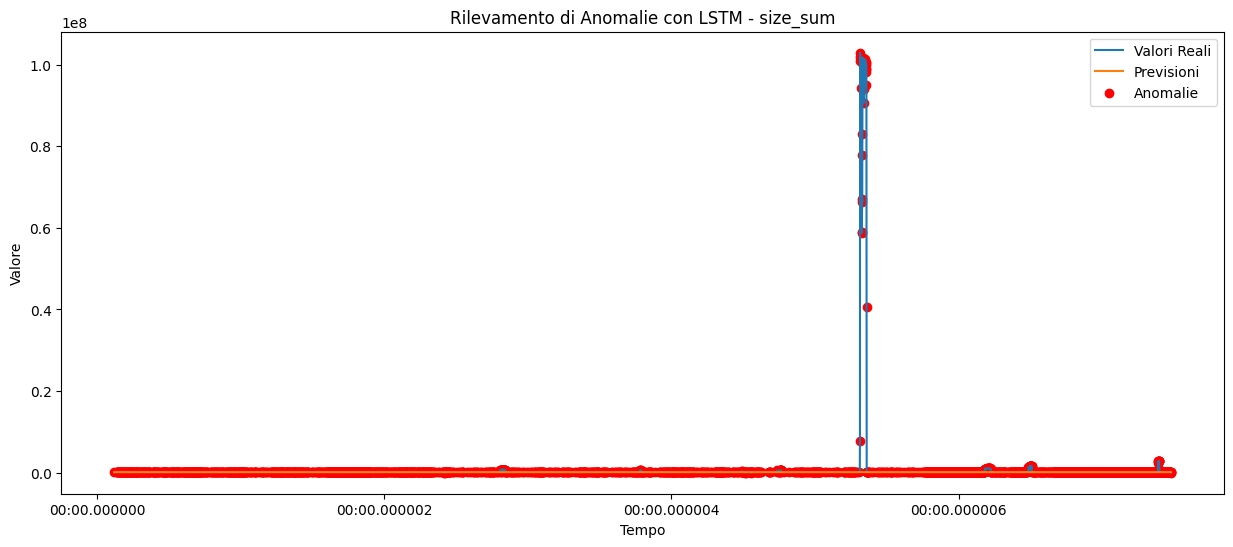

In [38]:
# Indice della feature di interesse
feature_name = 'size_sum'
feature_idx_in_targets = target_indices.index(features.index(feature_name))

# Preparazione dei dati per la visualizzazione
num_samples = len(y_test_inverse)
time_index = test_data.index[sequence_length:sequence_length + num_samples]

# Assicura che tutte le serie abbiano la stessa lunghezza
min_length = min(len(time_index), len(y_test_inverse), len(y_pred_inverse), len(residuals), len(anomalies))
time_index = time_index[:min_length]
actual = y_test_inverse[:min_length, feature_idx_in_targets]
prediction = y_pred_inverse[:min_length, feature_idx_in_targets]
residuals_for_plot = residuals[:min_length, feature_idx_in_targets]
anomalies = anomalies[:min_length]

# Creazione del DataFrame
results = pd.DataFrame({
    'time': time_index,
    'actual': actual,
    'prediction': prediction,
    'residual': residuals_for_plot,
    'anomaly': anomalies
})
results.set_index('time', inplace=True)


# Visualizza le anomalie sulla serie temporale
plt.figure(figsize=(15, 6))
plt.plot(results.index, results['actual'], label='Valori Reali')
plt.plot(results.index, results['prediction'], label='Previsioni')
plt.scatter(results.index[results['anomaly'] == 1], results['actual'][results['anomaly'] == 1], color='red', label='Anomalie')
plt.title(f'Rilevamento di Anomalie con LSTM - {feature_name}')
plt.xlabel('Tempo')
plt.ylabel('Valore')
plt.legend()
plt.show()